In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from sklearn.metrics import roc_curve, auc
from tqdm import tqdm
from backbone1 import DenseNet201b
from dataloader import create_dataloader
from metric import Metric
from ievit import IEViT2
torch.cuda.empty_cache()

# Set device to GPU if available, else use CPU
# device = torch.device("cuda:0")
device = torch.device("cuda")
print(f"Current device: {torch.cuda.get_device_name(torch.cuda.current_device())}" if torch.cuda.is_available() else "Current device: CPU")

Current device: NVIDIA RTX A6000


In [2]:
# Define hyperparameters
batch_size = 16
num_epochs = 200
learning_rate = 0.000001
in_channel = 3
image_size = 384
patch_size = 16
num_workers = 4
embed_dim = 960
mlp_dim = 1024
dim_feedforward = 1024
num_layers = 12
num_labels = 20
thresholds = [0.5] * num_labels
num_classes = 20
data_dir = '../data'

In [3]:
# Create dataloaders (image.shape = torch.Size([batch_size, channel_no, H, W])
train_dataloader = create_dataloader(data_dir=data_dir, batch_size=batch_size, num_workers=num_workers, size=image_size, phase='train')
val_dataloader = create_dataloader(data_dir=data_dir, batch_size=batch_size, num_workers=num_workers, size=image_size, phase='val')

384
384


In [4]:
# Define model and optimizer
backbone = DenseNet201b(embed_dim)
# create an instance of IEVIT
model = IEViT2(image_size, patch_size = patch_size, in_channels = in_channel, num_classes = num_classes, embed_dim = embed_dim,
               num_heads = num_workers, num_layers = num_layers, dim_feedforward = dim_feedforward, mlp_dim = mlp_dim, backbone=backbone)
model.to(device)

# Wrap your model with DataParallel
# model = nn.DataParallel(model, device_ids=[0, 1, 2, 3])

criterion = nn.BCEWithLogitsLoss()
# Define the optimizer and the learning rate scheduler
optimizer = torch.optim.AdamW(model.parameters(), lr=5e-5, weight_decay=1e-6)
scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer, T_0=10, T_mult=2)
#scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr=1e-3, epochs= num_epochs, steps_per_epoch=len(train_dataloader))

/home/deependra/project/rfmidc/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/deependra/project/rfmidc/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DenseNet201_Weights.IMAGENET1K_V1`. You can also use `weights=DenseNet201_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [5]:
# Initialize Metric class
metric = Metric(num_classes=num_classes)

# create empty lists to store predicted probabilities and true labels for each epoch
val_preds_all, val_labels_all = [], []

# define the epochs at which to plot the ROC curve
roc_epochs = [5,10,20,30,40,50,60,70,80,90,100,120,140,160,180,200]

# create empty lists to store ROC data for each epoch
roc_fpr = []
roc_tpr = []
roc_auc = []
f1_arr = []
loss_arr = []
model_arr = []
max_ms = [0,0]

# Train and evaluate model
for epoch in range(num_epochs):
    print(f"Epoch {epoch+1}/{num_epochs}")
    print('-' * 10)

    # Train phase
    model.train()
    for images, labels in tqdm(train_dataloader):
        images, labels = images.to(device), labels.to(device)
        
        # Forward pass
        outputs = model(images)
        
        loss = criterion(outputs, labels)    
        outputs = torch.sigmoid(outputs)
        
        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Compute metrics on train set
        with torch.no_grad():
            metric.update(outputs, labels, 0)
    
    # Print metrics on train set
    ml_f1_score, map_score, auc_score, ml_map_score, ml_auc_score, ml_score, bin_auc, model_score, bin_f1_score = metric.compute(1)
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}, ML mAP: {ml_map_score:.4f}, ML F1: {ml_f1_score:.4f}, ML AUC: {ml_auc_score:.4f}, ML Score: {ml_score:.4f}, Bin AUC: {bin_auc:.4f}, Model Score: {model_score:.4f}, Bin F1: {bin_f1_score:.4f}")

    # Reset Metric class for evaluation
    metric.reset()
    del images
    del labels
    del outputs
    torch.cuda.empty_cache()

    # Evaluate model on validation set
    model.eval()
    running_loss = 0.0
    val_preds, val_labels = [], []
    with torch.no_grad():
        for images, labels in tqdm(val_dataloader):
            images, labels = images.to(device), labels.to(device)
            
            # Forward pass
            outputs = model(images)
            running_loss += criterion(outputs, labels).item()
            outputs = torch.sigmoid(outputs)

            # append the predicted probabilities and true labels to lists for calculating ROC AUC score later
            val_preds += outputs.tolist()
            val_labels += labels.tolist()
            
            # Compute metrics on validation set
            metric.update(outputs, labels,1)
 
        # Print metrics on validation set
        ml_f1_score, map_score, auc_score, ml_map_score, ml_auc_score, ml_score, bin_auc, model_score, bin_f1_score = metric.compute(0)
        print(f"Val - Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}, ML mAP: {ml_map_score:.4f}, ML F1: {ml_f1_score:.4f}, ML AUC: {ml_auc_score:.4f}, ML Score: {ml_score:.4f}, Bin AUC: {bin_auc:.4f}, Model Score: {model_score:.4f}, Bin F1: {bin_f1_score:.4f}")
        
        f1_arr.append(ml_f1_score)
        model_arr.append(model_score)
        loss_arr.append(running_loss / len(val_dataloader))
        
        if max_ms[0] < model_score: 
            max_ms[0] = model_score
            max_ms[1] = epoch

        # append the predicted probabilities and true labels for this epoch to the lists for all epochs
        val_preds_all.append(val_preds)
        val_labels_all.append(val_labels)

        # check if the current epoch is in the list of epochs to plot ROC curve
        if epoch+1 in roc_epochs:
            # calculate ROC curve and AUC score for validation set
            fpr, tpr, roc_thresholds = roc_curve(np.concatenate(val_labels_all).ravel(), np.concatenate(val_preds_all).ravel())
            roc_fpr.append(fpr)
            roc_tpr.append(tpr)
            roc_auc.append(auc(fpr, tpr))

        print() # empty line for spacing
        
        # Reset Metric class for next epoch
        metric.reset()
        del images
        del labels
        del outputs
        torch.cuda.empty_cache()   
    
    # Step the learning rate scheduler
    scheduler.step()      

Epoch 1/200
----------


100%|██████████| 111/111 [01:04<00:00,  1.73it/s]


Epoch [1/200], Loss: 0.3159, ML mAP: 0.0800, ML F1: 0.0371, ML AUC: 0.4977, ML Score: 0.2889, Bin AUC: 0.3056, Model Score: 0.2972, Bin F1: 0.0000


100%|██████████| 28/28 [00:06<00:00,  4.12it/s]


Val - Epoch [1/200], Loss: 0.3159, ML mAP: 0.1591, ML F1: 0.0000, ML AUC: 0.6269, ML Score: 0.3930, Bin AUC: 0.1053, Model Score: 0.2491, Bin F1: 0.0000

Epoch 2/200
----------


100%|██████████| 111/111 [01:03<00:00,  1.74it/s]


Epoch [2/200], Loss: 0.2927, ML mAP: 0.1164, ML F1: 0.0206, ML AUC: 0.5822, ML Score: 0.3493, Bin AUC: 0.1053, Model Score: 0.2273, Bin F1: 0.0000


100%|██████████| 28/28 [00:06<00:00,  4.24it/s]


Val - Epoch [2/200], Loss: 0.2927, ML mAP: 0.2060, ML F1: 0.0131, ML AUC: 0.7809, ML Score: 0.4935, Bin AUC: 0.1579, Model Score: 0.3257, Bin F1: 0.0000

Epoch 3/200
----------


100%|██████████| 111/111 [01:04<00:00,  1.73it/s]


Epoch [3/200], Loss: 0.2376, ML mAP: 0.1774, ML F1: 0.0600, ML AUC: 0.7094, ML Score: 0.4434, Bin AUC: 0.3611, Model Score: 0.4022, Bin F1: 0.0000


100%|██████████| 28/28 [00:06<00:00,  4.24it/s]


Val - Epoch [3/200], Loss: 0.2376, ML mAP: 0.2964, ML F1: 0.0067, ML AUC: 0.8199, ML Score: 0.5582, Bin AUC: 0.9474, Model Score: 0.7528, Bin F1: 0.0000

Epoch 4/200
----------


100%|██████████| 111/111 [01:04<00:00,  1.73it/s]


Epoch [4/200], Loss: 0.2135, ML mAP: 0.2409, ML F1: 0.0935, ML AUC: 0.7865, ML Score: 0.5137, Bin AUC: 1.0000, Model Score: 0.7568, Bin F1: 0.0000


100%|██████████| 28/28 [00:06<00:00,  4.31it/s]


Val - Epoch [4/200], Loss: 0.2135, ML mAP: 0.3515, ML F1: 0.0925, ML AUC: 0.8478, ML Score: 0.5997, Bin AUC: 0.8421, Model Score: 0.7209, Bin F1: 0.0000

Epoch 5/200
----------


100%|██████████| 111/111 [01:04<00:00,  1.72it/s]


Epoch [5/200], Loss: 0.1866, ML mAP: 0.3215, ML F1: 0.1818, ML AUC: 0.8261, ML Score: 0.5738, Bin AUC: 0.8056, Model Score: 0.6897, Bin F1: 0.0000


100%|██████████| 28/28 [00:06<00:00,  4.22it/s]


Val - Epoch [5/200], Loss: 0.1866, ML mAP: 0.3604, ML F1: 0.1035, ML AUC: 0.8691, ML Score: 0.6148, Bin AUC: 0.7895, Model Score: 0.7021, Bin F1: 0.0000

Epoch 6/200
----------


100%|██████████| 111/111 [01:04<00:00,  1.73it/s]


Epoch [6/200], Loss: 0.2110, ML mAP: 0.3959, ML F1: 0.2196, ML AUC: 0.8580, ML Score: 0.6269, Bin AUC: 0.9474, Model Score: 0.7872, Bin F1: 0.0000


100%|██████████| 28/28 [00:06<00:00,  4.29it/s]


Val - Epoch [6/200], Loss: 0.2110, ML mAP: 0.4158, ML F1: 0.1209, ML AUC: 0.8811, ML Score: 0.6484, Bin AUC: 0.8421, Model Score: 0.7453, Bin F1: 0.0000

Epoch 7/200
----------


100%|██████████| 111/111 [01:04<00:00,  1.73it/s]


Epoch [7/200], Loss: 0.2450, ML mAP: 0.4979, ML F1: 0.3049, ML AUC: 0.8924, ML Score: 0.6951, Bin AUC: 0.9412, Model Score: 0.8181, Bin F1: 0.8000


100%|██████████| 28/28 [00:06<00:00,  4.19it/s]


Val - Epoch [7/200], Loss: 0.2450, ML mAP: 0.4525, ML F1: 0.1524, ML AUC: 0.8974, ML Score: 0.6749, Bin AUC: 0.8947, Model Score: 0.7848, Bin F1: 0.0000

Epoch 8/200
----------


100%|██████████| 111/111 [01:04<00:00,  1.72it/s]


Epoch [8/200], Loss: 0.1747, ML mAP: 0.5687, ML F1: 0.3700, ML AUC: 0.9089, ML Score: 0.7388, Bin AUC: 0.9474, Model Score: 0.8431, Bin F1: 0.0000


100%|██████████| 28/28 [00:06<00:00,  4.26it/s]


Val - Epoch [8/200], Loss: 0.1747, ML mAP: 0.4557, ML F1: 0.1820, ML AUC: 0.8996, ML Score: 0.6776, Bin AUC: 0.7895, Model Score: 0.7336, Bin F1: 0.0000

Epoch 9/200
----------


100%|██████████| 111/111 [01:04<00:00,  1.73it/s]


Epoch [9/200], Loss: 0.1339, ML mAP: 0.5954, ML F1: 0.3994, ML AUC: 0.9152, ML Score: 0.7553, Bin AUC: 1.0000, Model Score: 0.8776, Bin F1: 0.0000


100%|██████████| 28/28 [00:06<00:00,  4.15it/s]


Val - Epoch [9/200], Loss: 0.1339, ML mAP: 0.4794, ML F1: 0.1881, ML AUC: 0.9032, ML Score: 0.6913, Bin AUC: 0.7368, Model Score: 0.7141, Bin F1: 0.0000

Epoch 10/200
----------


100%|██████████| 111/111 [01:04<00:00,  1.73it/s]


Epoch [10/200], Loss: 0.1744, ML mAP: 0.6227, ML F1: 0.4175, ML AUC: 0.9202, ML Score: 0.7715, Bin AUC: 1.0000, Model Score: 0.8857, Bin F1: 0.0000


100%|██████████| 28/28 [00:06<00:00,  4.30it/s]


Val - Epoch [10/200], Loss: 0.1744, ML mAP: 0.4784, ML F1: 0.1903, ML AUC: 0.9025, ML Score: 0.6904, Bin AUC: 0.7368, Model Score: 0.7136, Bin F1: 0.0000

Epoch 11/200
----------


100%|██████████| 111/111 [01:04<00:00,  1.73it/s]


Epoch [11/200], Loss: 0.1829, ML mAP: 0.4878, ML F1: 0.3747, ML AUC: 0.8871, ML Score: 0.6875, Bin AUC: 1.0000, Model Score: 0.8437, Bin F1: 1.0000


100%|██████████| 28/28 [00:06<00:00,  4.28it/s]


Val - Epoch [11/200], Loss: 0.1829, ML mAP: 0.4910, ML F1: 0.2645, ML AUC: 0.8995, ML Score: 0.6952, Bin AUC: 0.7368, Model Score: 0.7160, Bin F1: 0.0000

Epoch 12/200
----------


100%|██████████| 111/111 [01:04<00:00,  1.73it/s]


Epoch [12/200], Loss: 0.1889, ML mAP: 0.5404, ML F1: 0.4452, ML AUC: 0.9030, ML Score: 0.7217, Bin AUC: 1.0000, Model Score: 0.8608, Bin F1: 1.0000


100%|██████████| 28/28 [00:06<00:00,  4.17it/s]


Val - Epoch [12/200], Loss: 0.1889, ML mAP: 0.5221, ML F1: 0.3277, ML AUC: 0.9081, ML Score: 0.7151, Bin AUC: 0.9474, Model Score: 0.8312, Bin F1: 0.0000

Epoch 13/200
----------


100%|██████████| 111/111 [01:04<00:00,  1.73it/s]


Epoch [13/200], Loss: 0.1593, ML mAP: 0.6175, ML F1: 0.5102, ML AUC: 0.9242, ML Score: 0.7709, Bin AUC: 0.8056, Model Score: 0.7882, Bin F1: 0.0000


100%|██████████| 28/28 [00:06<00:00,  4.26it/s]


Val - Epoch [13/200], Loss: 0.1593, ML mAP: 0.5442, ML F1: 0.3757, ML AUC: 0.9109, ML Score: 0.7275, Bin AUC: 1.0000, Model Score: 0.8638, Bin F1: 0.0000

Epoch 14/200
----------


100%|██████████| 111/111 [01:04<00:00,  1.73it/s]


Epoch [14/200], Loss: 0.1095, ML mAP: 0.6489, ML F1: 0.5505, ML AUC: 0.9332, ML Score: 0.7911, Bin AUC: 0.9020, Model Score: 0.8465, Bin F1: 0.4000


100%|██████████| 28/28 [00:06<00:00,  4.21it/s]


Val - Epoch [14/200], Loss: 0.1095, ML mAP: 0.5601, ML F1: 0.3961, ML AUC: 0.9173, ML Score: 0.7387, Bin AUC: 0.8947, Model Score: 0.8167, Bin F1: 0.0000

Epoch 15/200
----------


100%|██████████| 111/111 [01:04<00:00,  1.73it/s]


Epoch [15/200], Loss: 0.1827, ML mAP: 0.7317, ML F1: 0.6405, ML AUC: 0.9505, ML Score: 0.8411, Bin AUC: 1.0000, Model Score: 0.9206, Bin F1: 1.0000


100%|██████████| 28/28 [00:06<00:00,  4.28it/s]


Val - Epoch [15/200], Loss: 0.1827, ML mAP: 0.6074, ML F1: 0.4205, ML AUC: 0.9238, ML Score: 0.7656, Bin AUC: 1.0000, Model Score: 0.8828, Bin F1: 0.0000

Epoch 16/200
----------


100%|██████████| 111/111 [01:04<00:00,  1.73it/s]


Epoch [16/200], Loss: 0.1254, ML mAP: 0.7546, ML F1: 0.6733, ML AUC: 0.9578, ML Score: 0.8562, Bin AUC: 1.0000, Model Score: 0.9281, Bin F1: 0.6667


100%|██████████| 28/28 [00:06<00:00,  4.22it/s]


Val - Epoch [16/200], Loss: 0.1254, ML mAP: 0.5605, ML F1: 0.4382, ML AUC: 0.9212, ML Score: 0.7408, Bin AUC: 1.0000, Model Score: 0.8704, Bin F1: 0.0000

Epoch 17/200
----------


100%|██████████| 111/111 [01:04<00:00,  1.73it/s]


Epoch [17/200], Loss: 0.1116, ML mAP: 0.7741, ML F1: 0.6936, ML AUC: 0.9626, ML Score: 0.8684, Bin AUC: 1.0000, Model Score: 0.9342, Bin F1: 1.0000


100%|██████████| 28/28 [00:06<00:00,  4.25it/s]


Val - Epoch [17/200], Loss: 0.1116, ML mAP: 0.5989, ML F1: 0.5015, ML AUC: 0.9260, ML Score: 0.7625, Bin AUC: 1.0000, Model Score: 0.8812, Bin F1: 1.0000

Epoch 18/200
----------


100%|██████████| 111/111 [01:04<00:00,  1.72it/s]


Epoch [18/200], Loss: 0.1878, ML mAP: 0.8208, ML F1: 0.7474, ML AUC: 0.9699, ML Score: 0.8954, Bin AUC: 1.0000, Model Score: 0.9477, Bin F1: 1.0000


100%|██████████| 28/28 [00:06<00:00,  4.22it/s]


Val - Epoch [18/200], Loss: 0.1878, ML mAP: 0.6269, ML F1: 0.4800, ML AUC: 0.9329, ML Score: 0.7799, Bin AUC: 1.0000, Model Score: 0.8900, Bin F1: 1.0000

Epoch 19/200
----------


100%|██████████| 111/111 [01:04<00:00,  1.73it/s]


Epoch [19/200], Loss: 0.2076, ML mAP: 0.8459, ML F1: 0.7694, ML AUC: 0.9738, ML Score: 0.9098, Bin AUC: 1.0000, Model Score: 0.9549, Bin F1: 1.0000


100%|██████████| 28/28 [00:06<00:00,  4.21it/s]


Val - Epoch [19/200], Loss: 0.2076, ML mAP: 0.6133, ML F1: 0.5182, ML AUC: 0.9222, ML Score: 0.7677, Bin AUC: 1.0000, Model Score: 0.8839, Bin F1: 0.0000

Epoch 20/200
----------


100%|██████████| 111/111 [01:04<00:00,  1.73it/s]


Epoch [20/200], Loss: 0.1185, ML mAP: 0.8506, ML F1: 0.7770, ML AUC: 0.9748, ML Score: 0.9127, Bin AUC: 1.0000, Model Score: 0.9564, Bin F1: 1.0000


100%|██████████| 28/28 [00:06<00:00,  4.23it/s]


Val - Epoch [20/200], Loss: 0.1185, ML mAP: 0.6395, ML F1: 0.5312, ML AUC: 0.9360, ML Score: 0.7878, Bin AUC: 1.0000, Model Score: 0.8939, Bin F1: 0.0000

Epoch 21/200
----------


100%|██████████| 111/111 [01:04<00:00,  1.73it/s]


Epoch [21/200], Loss: 0.0813, ML mAP: 0.9014, ML F1: 0.8325, ML AUC: 0.9841, ML Score: 0.9428, Bin AUC: 1.0000, Model Score: 0.9714, Bin F1: 1.0000


100%|██████████| 28/28 [00:06<00:00,  4.27it/s]


Val - Epoch [21/200], Loss: 0.0813, ML mAP: 0.6237, ML F1: 0.5333, ML AUC: 0.9351, ML Score: 0.7794, Bin AUC: 1.0000, Model Score: 0.8897, Bin F1: 0.0000

Epoch 22/200
----------


100%|██████████| 111/111 [01:04<00:00,  1.73it/s]


Epoch [22/200], Loss: 0.0864, ML mAP: 0.9095, ML F1: 0.8409, ML AUC: 0.9847, ML Score: 0.9471, Bin AUC: 1.0000, Model Score: 0.9736, Bin F1: 1.0000


100%|██████████| 28/28 [00:06<00:00,  4.18it/s]


Val - Epoch [22/200], Loss: 0.0864, ML mAP: 0.6333, ML F1: 0.5766, ML AUC: 0.9360, ML Score: 0.7847, Bin AUC: 1.0000, Model Score: 0.8923, Bin F1: 1.0000

Epoch 23/200
----------


100%|██████████| 111/111 [01:04<00:00,  1.73it/s]


Epoch [23/200], Loss: 0.0994, ML mAP: 0.9291, ML F1: 0.8678, ML AUC: 0.9882, ML Score: 0.9586, Bin AUC: 1.0000, Model Score: 0.9793, Bin F1: 1.0000


100%|██████████| 28/28 [00:06<00:00,  4.20it/s]


Val - Epoch [23/200], Loss: 0.0994, ML mAP: 0.6365, ML F1: 0.5697, ML AUC: 0.9375, ML Score: 0.7870, Bin AUC: 1.0000, Model Score: 0.8935, Bin F1: 1.0000

Epoch 24/200
----------


100%|██████████| 111/111 [01:04<00:00,  1.73it/s]


Epoch [24/200], Loss: 0.3650, ML mAP: 0.9389, ML F1: 0.8858, ML AUC: 0.9903, ML Score: 0.9646, Bin AUC: 1.0000, Model Score: 0.9823, Bin F1: 1.0000


100%|██████████| 28/28 [00:06<00:00,  4.26it/s]


Val - Epoch [24/200], Loss: 0.3650, ML mAP: 0.6418, ML F1: 0.5655, ML AUC: 0.9324, ML Score: 0.7871, Bin AUC: 1.0000, Model Score: 0.8936, Bin F1: 1.0000

Epoch 25/200
----------


100%|██████████| 111/111 [01:04<00:00,  1.73it/s]


Epoch [25/200], Loss: 0.0565, ML mAP: 0.9410, ML F1: 0.8874, ML AUC: 0.9916, ML Score: 0.9663, Bin AUC: 1.0000, Model Score: 0.9831, Bin F1: 1.0000


100%|██████████| 28/28 [00:06<00:00,  4.27it/s]


Val - Epoch [25/200], Loss: 0.0565, ML mAP: 0.6509, ML F1: 0.5727, ML AUC: 0.9354, ML Score: 0.7932, Bin AUC: 1.0000, Model Score: 0.8966, Bin F1: 1.0000

Epoch 26/200
----------


100%|██████████| 111/111 [01:03<00:00,  1.74it/s]


Epoch [26/200], Loss: 0.1333, ML mAP: 0.9585, ML F1: 0.9056, ML AUC: 0.9939, ML Score: 0.9762, Bin AUC: 1.0000, Model Score: 0.9881, Bin F1: 0.8000


100%|██████████| 28/28 [00:06<00:00,  4.20it/s]


Val - Epoch [26/200], Loss: 0.1333, ML mAP: 0.6553, ML F1: 0.5962, ML AUC: 0.9389, ML Score: 0.7971, Bin AUC: 1.0000, Model Score: 0.8986, Bin F1: 0.0000

Epoch 27/200
----------


100%|██████████| 111/111 [01:04<00:00,  1.73it/s]


Epoch [27/200], Loss: 0.0451, ML mAP: 0.9514, ML F1: 0.9019, ML AUC: 0.9935, ML Score: 0.9725, Bin AUC: 1.0000, Model Score: 0.9862, Bin F1: 1.0000


100%|██████████| 28/28 [00:06<00:00,  4.28it/s]


Val - Epoch [27/200], Loss: 0.0451, ML mAP: 0.6560, ML F1: 0.5730, ML AUC: 0.9406, ML Score: 0.7983, Bin AUC: 1.0000, Model Score: 0.8992, Bin F1: 1.0000

Epoch 28/200
----------


100%|██████████| 111/111 [01:04<00:00,  1.72it/s]


Epoch [28/200], Loss: 0.0488, ML mAP: 0.9566, ML F1: 0.9022, ML AUC: 0.9931, ML Score: 0.9749, Bin AUC: 1.0000, Model Score: 0.9874, Bin F1: 1.0000


100%|██████████| 28/28 [00:06<00:00,  4.25it/s]


Val - Epoch [28/200], Loss: 0.0488, ML mAP: 0.6654, ML F1: 0.5874, ML AUC: 0.9387, ML Score: 0.8020, Bin AUC: 1.0000, Model Score: 0.9010, Bin F1: 0.0000

Epoch 29/200
----------


100%|██████████| 111/111 [01:04<00:00,  1.73it/s]


Epoch [29/200], Loss: 0.0492, ML mAP: 0.9631, ML F1: 0.9188, ML AUC: 0.9944, ML Score: 0.9788, Bin AUC: 1.0000, Model Score: 0.9894, Bin F1: 1.0000


100%|██████████| 28/28 [00:06<00:00,  4.29it/s]


Val - Epoch [29/200], Loss: 0.0492, ML mAP: 0.6622, ML F1: 0.6046, ML AUC: 0.9398, ML Score: 0.8010, Bin AUC: 1.0000, Model Score: 0.9005, Bin F1: 0.0000

Epoch 30/200
----------


100%|██████████| 111/111 [01:04<00:00,  1.72it/s]


Epoch [30/200], Loss: 0.0700, ML mAP: 0.9612, ML F1: 0.9087, ML AUC: 0.9942, ML Score: 0.9777, Bin AUC: 1.0000, Model Score: 0.9889, Bin F1: 1.0000


100%|██████████| 28/28 [00:06<00:00,  4.29it/s]


Val - Epoch [30/200], Loss: 0.0700, ML mAP: 0.6657, ML F1: 0.6019, ML AUC: 0.9386, ML Score: 0.8022, Bin AUC: 1.0000, Model Score: 0.9011, Bin F1: 0.0000

Epoch 31/200
----------


100%|██████████| 111/111 [01:04<00:00,  1.73it/s]


Epoch [31/200], Loss: 0.0994, ML mAP: 0.9213, ML F1: 0.8596, ML AUC: 0.9864, ML Score: 0.9538, Bin AUC: 0.9474, Model Score: 0.9506, Bin F1: 0.0000


100%|██████████| 28/28 [00:06<00:00,  4.28it/s]


Val - Epoch [31/200], Loss: 0.0994, ML mAP: 0.6494, ML F1: 0.5497, ML AUC: 0.9358, ML Score: 0.7926, Bin AUC: 1.0000, Model Score: 0.8963, Bin F1: 0.0000

Epoch 32/200
----------


100%|██████████| 111/111 [01:04<00:00,  1.73it/s]


Epoch [32/200], Loss: 0.0517, ML mAP: 0.8978, ML F1: 0.8348, ML AUC: 0.9845, ML Score: 0.9411, Bin AUC: 0.9474, Model Score: 0.9442, Bin F1: 0.0000


100%|██████████| 28/28 [00:06<00:00,  4.20it/s]


Val - Epoch [32/200], Loss: 0.0517, ML mAP: 0.6042, ML F1: 0.5299, ML AUC: 0.9234, ML Score: 0.7638, Bin AUC: 0.9474, Model Score: 0.8556, Bin F1: 0.0000

Epoch 33/200
----------


100%|██████████| 111/111 [01:04<00:00,  1.73it/s]


Epoch [33/200], Loss: 0.1590, ML mAP: 0.9136, ML F1: 0.8498, ML AUC: 0.9871, ML Score: 0.9504, Bin AUC: 1.0000, Model Score: 0.9752, Bin F1: 1.0000


100%|██████████| 28/28 [00:06<00:00,  4.27it/s]


Val - Epoch [33/200], Loss: 0.1590, ML mAP: 0.6289, ML F1: 0.5553, ML AUC: 0.9321, ML Score: 0.7805, Bin AUC: 1.0000, Model Score: 0.8902, Bin F1: 0.0000

Epoch 34/200
----------


100%|██████████| 111/111 [01:04<00:00,  1.73it/s]


Epoch [34/200], Loss: 0.0719, ML mAP: 0.9334, ML F1: 0.8712, ML AUC: 0.9907, ML Score: 0.9620, Bin AUC: 0.8889, Model Score: 0.9255, Bin F1: 0.6667


100%|██████████| 28/28 [00:06<00:00,  4.26it/s]


Val - Epoch [34/200], Loss: 0.0719, ML mAP: 0.6155, ML F1: 0.5343, ML AUC: 0.9245, ML Score: 0.7700, Bin AUC: 1.0000, Model Score: 0.8850, Bin F1: 1.0000

Epoch 35/200
----------


100%|██████████| 111/111 [01:04<00:00,  1.73it/s]


Epoch [35/200], Loss: 0.1372, ML mAP: 0.9327, ML F1: 0.8739, ML AUC: 0.9902, ML Score: 0.9615, Bin AUC: 0.6842, Model Score: 0.8228, Bin F1: 0.0000


100%|██████████| 28/28 [00:06<00:00,  4.21it/s]


Val - Epoch [35/200], Loss: 0.1372, ML mAP: 0.6281, ML F1: 0.5392, ML AUC: 0.9243, ML Score: 0.7762, Bin AUC: 1.0000, Model Score: 0.8881, Bin F1: 0.0000

Epoch 36/200
----------


100%|██████████| 111/111 [01:04<00:00,  1.73it/s]


Epoch [36/200], Loss: 0.0657, ML mAP: 0.9310, ML F1: 0.8764, ML AUC: 0.9894, ML Score: 0.9602, Bin AUC: 1.0000, Model Score: 0.9801, Bin F1: 0.8000


100%|██████████| 28/28 [00:06<00:00,  4.28it/s]


Val - Epoch [36/200], Loss: 0.0657, ML mAP: 0.6208, ML F1: 0.5397, ML AUC: 0.9283, ML Score: 0.7746, Bin AUC: 0.9474, Model Score: 0.8610, Bin F1: 0.0000

Epoch 37/200
----------


100%|██████████| 111/111 [01:04<00:00,  1.73it/s]


Epoch [37/200], Loss: 0.0453, ML mAP: 0.9484, ML F1: 0.8976, ML AUC: 0.9928, ML Score: 0.9706, Bin AUC: 1.0000, Model Score: 0.9853, Bin F1: 1.0000


100%|██████████| 28/28 [00:06<00:00,  4.15it/s]


Val - Epoch [37/200], Loss: 0.0453, ML mAP: 0.6302, ML F1: 0.5684, ML AUC: 0.9273, ML Score: 0.7788, Bin AUC: 1.0000, Model Score: 0.8894, Bin F1: 0.0000

Epoch 38/200
----------


100%|██████████| 111/111 [01:04<00:00,  1.73it/s]


Epoch [38/200], Loss: 0.1091, ML mAP: 0.9594, ML F1: 0.9103, ML AUC: 0.9943, ML Score: 0.9768, Bin AUC: 1.0000, Model Score: 0.9884, Bin F1: 1.0000


100%|██████████| 28/28 [00:06<00:00,  4.25it/s]


Val - Epoch [38/200], Loss: 0.1091, ML mAP: 0.6351, ML F1: 0.5867, ML AUC: 0.9341, ML Score: 0.7846, Bin AUC: 1.0000, Model Score: 0.8923, Bin F1: 0.0000

Epoch 39/200
----------


100%|██████████| 111/111 [01:04<00:00,  1.73it/s]


Epoch [39/200], Loss: 0.0701, ML mAP: 0.9622, ML F1: 0.9186, ML AUC: 0.9950, ML Score: 0.9786, Bin AUC: 0.9444, Model Score: 0.9615, Bin F1: 0.5000


100%|██████████| 28/28 [00:06<00:00,  4.23it/s]


Val - Epoch [39/200], Loss: 0.0701, ML mAP: 0.6533, ML F1: 0.5892, ML AUC: 0.9297, ML Score: 0.7915, Bin AUC: 1.0000, Model Score: 0.8958, Bin F1: 0.0000

Epoch 40/200
----------


100%|██████████| 111/111 [01:03<00:00,  1.74it/s]


Epoch [40/200], Loss: 0.1795, ML mAP: 0.9654, ML F1: 0.9154, ML AUC: 0.9955, ML Score: 0.9805, Bin AUC: 1.0000, Model Score: 0.9902, Bin F1: 1.0000


100%|██████████| 28/28 [00:06<00:00,  4.20it/s]


Val - Epoch [40/200], Loss: 0.1795, ML mAP: 0.6263, ML F1: 0.5622, ML AUC: 0.9236, ML Score: 0.7750, Bin AUC: 1.0000, Model Score: 0.8875, Bin F1: 1.0000

Epoch 41/200
----------


100%|██████████| 111/111 [01:04<00:00,  1.73it/s]


Epoch [41/200], Loss: 0.1962, ML mAP: 0.9646, ML F1: 0.9169, ML AUC: 0.9948, ML Score: 0.9797, Bin AUC: 1.0000, Model Score: 0.9899, Bin F1: 1.0000


100%|██████████| 28/28 [00:06<00:00,  4.28it/s]


Val - Epoch [41/200], Loss: 0.1962, ML mAP: 0.6373, ML F1: 0.5926, ML AUC: 0.9264, ML Score: 0.7818, Bin AUC: 1.0000, Model Score: 0.8909, Bin F1: 1.0000

Epoch 42/200
----------


100%|██████████| 111/111 [01:04<00:00,  1.73it/s]


Epoch [42/200], Loss: 0.0646, ML mAP: 0.9684, ML F1: 0.9250, ML AUC: 0.9954, ML Score: 0.9819, Bin AUC: 1.0000, Model Score: 0.9910, Bin F1: 1.0000


100%|██████████| 28/28 [00:06<00:00,  4.30it/s]


Val - Epoch [42/200], Loss: 0.0646, ML mAP: 0.6480, ML F1: 0.5863, ML AUC: 0.9289, ML Score: 0.7885, Bin AUC: 1.0000, Model Score: 0.8942, Bin F1: 1.0000

Epoch 43/200
----------


100%|██████████| 111/111 [01:04<00:00,  1.73it/s]


Epoch [43/200], Loss: 0.0224, ML mAP: 0.9707, ML F1: 0.9268, ML AUC: 0.9961, ML Score: 0.9834, Bin AUC: 1.0000, Model Score: 0.9917, Bin F1: 0.8000


100%|██████████| 28/28 [00:06<00:00,  4.28it/s]


Val - Epoch [43/200], Loss: 0.0224, ML mAP: 0.6382, ML F1: 0.5977, ML AUC: 0.9324, ML Score: 0.7853, Bin AUC: 1.0000, Model Score: 0.8927, Bin F1: 1.0000

Epoch 44/200
----------


100%|██████████| 111/111 [01:04<00:00,  1.72it/s]


Epoch [44/200], Loss: 0.1334, ML mAP: 0.9800, ML F1: 0.9448, ML AUC: 0.9978, ML Score: 0.9889, Bin AUC: 1.0000, Model Score: 0.9944, Bin F1: 1.0000


100%|██████████| 28/28 [00:06<00:00,  4.28it/s]


Val - Epoch [44/200], Loss: 0.1334, ML mAP: 0.6621, ML F1: 0.6071, ML AUC: 0.9282, ML Score: 0.7951, Bin AUC: 1.0000, Model Score: 0.8976, Bin F1: 1.0000

Epoch 45/200
----------


100%|██████████| 111/111 [01:04<00:00,  1.73it/s]


Epoch [45/200], Loss: 0.0892, ML mAP: 0.9746, ML F1: 0.9380, ML AUC: 0.9957, ML Score: 0.9852, Bin AUC: 1.0000, Model Score: 0.9926, Bin F1: 0.6667


100%|██████████| 28/28 [00:06<00:00,  4.28it/s]


Val - Epoch [45/200], Loss: 0.0892, ML mAP: 0.6339, ML F1: 0.5650, ML AUC: 0.9306, ML Score: 0.7822, Bin AUC: 1.0000, Model Score: 0.8911, Bin F1: 1.0000

Epoch 46/200
----------


100%|██████████| 111/111 [01:04<00:00,  1.73it/s]


Epoch [46/200], Loss: 0.0760, ML mAP: 0.9832, ML F1: 0.9502, ML AUC: 0.9982, ML Score: 0.9907, Bin AUC: 0.8947, Model Score: 0.9427, Bin F1: 0.0000


100%|██████████| 28/28 [00:06<00:00,  4.25it/s]


Val - Epoch [46/200], Loss: 0.0760, ML mAP: 0.6511, ML F1: 0.6155, ML AUC: 0.9311, ML Score: 0.7911, Bin AUC: 1.0000, Model Score: 0.8956, Bin F1: 1.0000

Epoch 47/200
----------


100%|██████████| 111/111 [01:04<00:00,  1.73it/s]


Epoch [47/200], Loss: 0.0407, ML mAP: 0.9811, ML F1: 0.9475, ML AUC: 0.9971, ML Score: 0.9891, Bin AUC: 1.0000, Model Score: 0.9946, Bin F1: 1.0000


100%|██████████| 28/28 [00:06<00:00,  4.28it/s]


Val - Epoch [47/200], Loss: 0.0407, ML mAP: 0.6327, ML F1: 0.5495, ML AUC: 0.9224, ML Score: 0.7776, Bin AUC: 1.0000, Model Score: 0.8888, Bin F1: 1.0000

Epoch 48/200
----------


100%|██████████| 111/111 [01:04<00:00,  1.73it/s]


Epoch [48/200], Loss: 0.0045, ML mAP: 0.9888, ML F1: 0.9579, ML AUC: 0.9982, ML Score: 0.9935, Bin AUC: 1.0000, Model Score: 0.9968, Bin F1: 1.0000


100%|██████████| 28/28 [00:06<00:00,  4.29it/s]


Val - Epoch [48/200], Loss: 0.0045, ML mAP: 0.6161, ML F1: 0.5478, ML AUC: 0.9187, ML Score: 0.7674, Bin AUC: 1.0000, Model Score: 0.8837, Bin F1: 1.0000

Epoch 49/200
----------


100%|██████████| 111/111 [01:04<00:00,  1.72it/s]


Epoch [49/200], Loss: 0.0123, ML mAP: 0.9871, ML F1: 0.9610, ML AUC: 0.9986, ML Score: 0.9928, Bin AUC: 1.0000, Model Score: 0.9964, Bin F1: 1.0000


100%|██████████| 28/28 [00:06<00:00,  4.29it/s]


Val - Epoch [49/200], Loss: 0.0123, ML mAP: 0.6553, ML F1: 0.6126, ML AUC: 0.9303, ML Score: 0.7928, Bin AUC: 1.0000, Model Score: 0.8964, Bin F1: 1.0000

Epoch 50/200
----------


100%|██████████| 111/111 [01:04<00:00,  1.72it/s]


Epoch [50/200], Loss: 0.0230, ML mAP: 0.9900, ML F1: 0.9645, ML AUC: 0.9989, ML Score: 0.9945, Bin AUC: 1.0000, Model Score: 0.9972, Bin F1: 1.0000


100%|██████████| 28/28 [00:06<00:00,  4.31it/s]


Val - Epoch [50/200], Loss: 0.0230, ML mAP: 0.6334, ML F1: 0.5668, ML AUC: 0.9168, ML Score: 0.7751, Bin AUC: 1.0000, Model Score: 0.8876, Bin F1: 0.0000

Epoch 51/200
----------


100%|██████████| 111/111 [01:04<00:00,  1.73it/s]


Epoch [51/200], Loss: 0.0170, ML mAP: 0.9869, ML F1: 0.9601, ML AUC: 0.9985, ML Score: 0.9927, Bin AUC: 1.0000, Model Score: 0.9964, Bin F1: 1.0000


100%|██████████| 28/28 [00:06<00:00,  4.16it/s]


Val - Epoch [51/200], Loss: 0.0170, ML mAP: 0.6373, ML F1: 0.5756, ML AUC: 0.9228, ML Score: 0.7800, Bin AUC: 1.0000, Model Score: 0.8900, Bin F1: 1.0000

Epoch 52/200
----------


100%|██████████| 111/111 [01:04<00:00,  1.73it/s]


Epoch [52/200], Loss: 0.0965, ML mAP: 0.9910, ML F1: 0.9685, ML AUC: 0.9990, ML Score: 0.9950, Bin AUC: 1.0000, Model Score: 0.9975, Bin F1: 1.0000


100%|██████████| 28/28 [00:06<00:00,  4.18it/s]


Val - Epoch [52/200], Loss: 0.0965, ML mAP: 0.6485, ML F1: 0.5783, ML AUC: 0.9235, ML Score: 0.7860, Bin AUC: 1.0000, Model Score: 0.8930, Bin F1: 1.0000

Epoch 53/200
----------


100%|██████████| 111/111 [01:04<00:00,  1.73it/s]


Epoch [53/200], Loss: 0.0435, ML mAP: 0.9909, ML F1: 0.9714, ML AUC: 0.9989, ML Score: 0.9949, Bin AUC: 1.0000, Model Score: 0.9975, Bin F1: 1.0000


100%|██████████| 28/28 [00:06<00:00,  4.24it/s]


Val - Epoch [53/200], Loss: 0.0435, ML mAP: 0.6405, ML F1: 0.5862, ML AUC: 0.9231, ML Score: 0.7818, Bin AUC: 1.0000, Model Score: 0.8909, Bin F1: 1.0000

Epoch 54/200
----------


100%|██████████| 111/111 [01:04<00:00,  1.73it/s]


Epoch [54/200], Loss: 0.0262, ML mAP: 0.9907, ML F1: 0.9707, ML AUC: 0.9987, ML Score: 0.9947, Bin AUC: 1.0000, Model Score: 0.9973, Bin F1: 1.0000


100%|██████████| 28/28 [00:06<00:00,  4.23it/s]


Val - Epoch [54/200], Loss: 0.0262, ML mAP: 0.6434, ML F1: 0.5946, ML AUC: 0.9232, ML Score: 0.7833, Bin AUC: 1.0000, Model Score: 0.8916, Bin F1: 1.0000

Epoch 55/200
----------


100%|██████████| 111/111 [01:04<00:00,  1.72it/s]


Epoch [55/200], Loss: 0.0532, ML mAP: 0.9951, ML F1: 0.9759, ML AUC: 0.9993, ML Score: 0.9972, Bin AUC: 1.0000, Model Score: 0.9986, Bin F1: 1.0000


100%|██████████| 28/28 [00:06<00:00,  4.25it/s]


Val - Epoch [55/200], Loss: 0.0532, ML mAP: 0.6317, ML F1: 0.5805, ML AUC: 0.9168, ML Score: 0.7742, Bin AUC: 1.0000, Model Score: 0.8871, Bin F1: 1.0000

Epoch 56/200
----------


100%|██████████| 111/111 [01:04<00:00,  1.73it/s]


Epoch [56/200], Loss: 0.0085, ML mAP: 0.9957, ML F1: 0.9794, ML AUC: 0.9995, ML Score: 0.9976, Bin AUC: 1.0000, Model Score: 0.9988, Bin F1: 1.0000


100%|██████████| 28/28 [00:06<00:00,  4.20it/s]


Val - Epoch [56/200], Loss: 0.0085, ML mAP: 0.6299, ML F1: 0.5701, ML AUC: 0.9220, ML Score: 0.7759, Bin AUC: 1.0000, Model Score: 0.8880, Bin F1: 1.0000

Epoch 57/200
----------


100%|██████████| 111/111 [01:04<00:00,  1.73it/s]


Epoch [57/200], Loss: 0.0062, ML mAP: 0.9941, ML F1: 0.9770, ML AUC: 0.9992, ML Score: 0.9966, Bin AUC: 1.0000, Model Score: 0.9983, Bin F1: 1.0000


100%|██████████| 28/28 [00:06<00:00,  4.18it/s]


Val - Epoch [57/200], Loss: 0.0062, ML mAP: 0.6352, ML F1: 0.5870, ML AUC: 0.9272, ML Score: 0.7812, Bin AUC: 1.0000, Model Score: 0.8906, Bin F1: 1.0000

Epoch 58/200
----------


100%|██████████| 111/111 [01:04<00:00,  1.72it/s]


Epoch [58/200], Loss: 0.0079, ML mAP: 0.9951, ML F1: 0.9779, ML AUC: 0.9995, ML Score: 0.9973, Bin AUC: 1.0000, Model Score: 0.9986, Bin F1: 1.0000


100%|██████████| 28/28 [00:06<00:00,  4.20it/s]


Val - Epoch [58/200], Loss: 0.0079, ML mAP: 0.6363, ML F1: 0.5952, ML AUC: 0.9239, ML Score: 0.7801, Bin AUC: 1.0000, Model Score: 0.8900, Bin F1: 1.0000

Epoch 59/200
----------


100%|██████████| 111/111 [01:04<00:00,  1.73it/s]


Epoch [59/200], Loss: 0.0236, ML mAP: 0.9962, ML F1: 0.9817, ML AUC: 0.9995, ML Score: 0.9979, Bin AUC: 1.0000, Model Score: 0.9989, Bin F1: 1.0000


100%|██████████| 28/28 [00:06<00:00,  4.26it/s]


Val - Epoch [59/200], Loss: 0.0236, ML mAP: 0.6344, ML F1: 0.5719, ML AUC: 0.9232, ML Score: 0.7788, Bin AUC: 1.0000, Model Score: 0.8894, Bin F1: 1.0000

Epoch 60/200
----------


100%|██████████| 111/111 [01:04<00:00,  1.73it/s]


Epoch [60/200], Loss: 0.0103, ML mAP: 0.9972, ML F1: 0.9826, ML AUC: 0.9997, ML Score: 0.9985, Bin AUC: 1.0000, Model Score: 0.9992, Bin F1: 1.0000


100%|██████████| 28/28 [00:06<00:00,  4.22it/s]


Val - Epoch [60/200], Loss: 0.0103, ML mAP: 0.6466, ML F1: 0.6045, ML AUC: 0.9240, ML Score: 0.7853, Bin AUC: 1.0000, Model Score: 0.8927, Bin F1: 1.0000

Epoch 61/200
----------


100%|██████████| 111/111 [01:04<00:00,  1.73it/s]


Epoch [61/200], Loss: 0.0030, ML mAP: 0.9956, ML F1: 0.9817, ML AUC: 0.9996, ML Score: 0.9976, Bin AUC: 1.0000, Model Score: 0.9988, Bin F1: 1.0000


100%|██████████| 28/28 [00:06<00:00,  4.23it/s]


Val - Epoch [61/200], Loss: 0.0030, ML mAP: 0.6438, ML F1: 0.6022, ML AUC: 0.9236, ML Score: 0.7837, Bin AUC: 1.0000, Model Score: 0.8918, Bin F1: 1.0000

Epoch 62/200
----------


100%|██████████| 111/111 [01:04<00:00,  1.73it/s]


Epoch [62/200], Loss: 0.0331, ML mAP: 0.9963, ML F1: 0.9835, ML AUC: 0.9996, ML Score: 0.9979, Bin AUC: 1.0000, Model Score: 0.9990, Bin F1: 1.0000


100%|██████████| 28/28 [00:06<00:00,  4.25it/s]


Val - Epoch [62/200], Loss: 0.0331, ML mAP: 0.6431, ML F1: 0.5986, ML AUC: 0.9228, ML Score: 0.7830, Bin AUC: 1.0000, Model Score: 0.8915, Bin F1: 1.0000

Epoch 63/200
----------


100%|██████████| 111/111 [01:04<00:00,  1.73it/s]


Epoch [63/200], Loss: 0.0204, ML mAP: 0.9971, ML F1: 0.9852, ML AUC: 0.9995, ML Score: 0.9983, Bin AUC: 1.0000, Model Score: 0.9991, Bin F1: 1.0000


100%|██████████| 28/28 [00:06<00:00,  4.28it/s]


Val - Epoch [63/200], Loss: 0.0204, ML mAP: 0.6343, ML F1: 0.5924, ML AUC: 0.9240, ML Score: 0.7791, Bin AUC: 1.0000, Model Score: 0.8896, Bin F1: 1.0000

Epoch 64/200
----------


100%|██████████| 111/111 [01:04<00:00,  1.72it/s]


Epoch [64/200], Loss: 0.0582, ML mAP: 0.9962, ML F1: 0.9822, ML AUC: 0.9995, ML Score: 0.9979, Bin AUC: 1.0000, Model Score: 0.9989, Bin F1: 1.0000


100%|██████████| 28/28 [00:06<00:00,  4.25it/s]


Val - Epoch [64/200], Loss: 0.0582, ML mAP: 0.6451, ML F1: 0.5998, ML AUC: 0.9220, ML Score: 0.7836, Bin AUC: 1.0000, Model Score: 0.8918, Bin F1: 1.0000

Epoch 65/200
----------


100%|██████████| 111/111 [01:04<00:00,  1.72it/s]


Epoch [65/200], Loss: 0.1269, ML mAP: 0.9972, ML F1: 0.9859, ML AUC: 0.9997, ML Score: 0.9985, Bin AUC: 1.0000, Model Score: 0.9992, Bin F1: 1.0000


100%|██████████| 28/28 [00:06<00:00,  4.26it/s]


Val - Epoch [65/200], Loss: 0.1269, ML mAP: 0.6463, ML F1: 0.6057, ML AUC: 0.9241, ML Score: 0.7852, Bin AUC: 1.0000, Model Score: 0.8926, Bin F1: 1.0000

Epoch 66/200
----------


100%|██████████| 111/111 [01:04<00:00,  1.72it/s]


Epoch [66/200], Loss: 0.0057, ML mAP: 0.9970, ML F1: 0.9863, ML AUC: 0.9995, ML Score: 0.9982, Bin AUC: 1.0000, Model Score: 0.9991, Bin F1: 1.0000


100%|██████████| 28/28 [00:06<00:00,  4.18it/s]


Val - Epoch [66/200], Loss: 0.0057, ML mAP: 0.6443, ML F1: 0.6058, ML AUC: 0.9226, ML Score: 0.7835, Bin AUC: 1.0000, Model Score: 0.8917, Bin F1: 1.0000

Epoch 67/200
----------


100%|██████████| 111/111 [01:03<00:00,  1.73it/s]


Epoch [67/200], Loss: 0.0415, ML mAP: 0.9991, ML F1: 0.9909, ML AUC: 0.9999, ML Score: 0.9995, Bin AUC: 1.0000, Model Score: 0.9998, Bin F1: 1.0000


100%|██████████| 28/28 [00:06<00:00,  4.27it/s]


Val - Epoch [67/200], Loss: 0.0415, ML mAP: 0.6419, ML F1: 0.5949, ML AUC: 0.9238, ML Score: 0.7829, Bin AUC: 1.0000, Model Score: 0.8914, Bin F1: 1.0000

Epoch 68/200
----------


100%|██████████| 111/111 [01:04<00:00,  1.73it/s]


Epoch [68/200], Loss: 0.0043, ML mAP: 0.9986, ML F1: 0.9902, ML AUC: 0.9999, ML Score: 0.9992, Bin AUC: 1.0000, Model Score: 0.9996, Bin F1: 1.0000


100%|██████████| 28/28 [00:06<00:00,  4.16it/s]


Val - Epoch [68/200], Loss: 0.0043, ML mAP: 0.6389, ML F1: 0.5935, ML AUC: 0.9231, ML Score: 0.7810, Bin AUC: 1.0000, Model Score: 0.8905, Bin F1: 1.0000

Epoch 69/200
----------


100%|██████████| 111/111 [01:04<00:00,  1.73it/s]


Epoch [69/200], Loss: 0.0027, ML mAP: 0.9979, ML F1: 0.9898, ML AUC: 0.9998, ML Score: 0.9989, Bin AUC: 1.0000, Model Score: 0.9994, Bin F1: 1.0000


100%|██████████| 28/28 [00:06<00:00,  4.29it/s]


Val - Epoch [69/200], Loss: 0.0027, ML mAP: 0.6441, ML F1: 0.6037, ML AUC: 0.9235, ML Score: 0.7838, Bin AUC: 1.0000, Model Score: 0.8919, Bin F1: 1.0000

Epoch 70/200
----------


100%|██████████| 111/111 [01:04<00:00,  1.73it/s]


Epoch [70/200], Loss: 0.0121, ML mAP: 0.9960, ML F1: 0.9855, ML AUC: 0.9991, ML Score: 0.9976, Bin AUC: 1.0000, Model Score: 0.9988, Bin F1: 1.0000


100%|██████████| 28/28 [00:06<00:00,  4.17it/s]


Val - Epoch [70/200], Loss: 0.0121, ML mAP: 0.6455, ML F1: 0.6014, ML AUC: 0.9244, ML Score: 0.7849, Bin AUC: 1.0000, Model Score: 0.8925, Bin F1: 1.0000

Epoch 71/200
----------


100%|██████████| 111/111 [01:04<00:00,  1.72it/s]


Epoch [71/200], Loss: 0.1035, ML mAP: 0.9683, ML F1: 0.9246, ML AUC: 0.9951, ML Score: 0.9817, Bin AUC: 1.0000, Model Score: 0.9909, Bin F1: 1.0000


100%|██████████| 28/28 [00:06<00:00,  4.29it/s]


Val - Epoch [71/200], Loss: 0.1035, ML mAP: 0.6144, ML F1: 0.4692, ML AUC: 0.9195, ML Score: 0.7669, Bin AUC: 0.8947, Model Score: 0.8308, Bin F1: 0.0000

Epoch 72/200
----------


100%|██████████| 111/111 [01:04<00:00,  1.72it/s]


Epoch [72/200], Loss: 0.0426, ML mAP: 0.9189, ML F1: 0.8595, ML AUC: 0.9877, ML Score: 0.9533, Bin AUC: 1.0000, Model Score: 0.9766, Bin F1: 1.0000


100%|██████████| 28/28 [00:06<00:00,  4.21it/s]


Val - Epoch [72/200], Loss: 0.0426, ML mAP: 0.6128, ML F1: 0.5513, ML AUC: 0.9212, ML Score: 0.7670, Bin AUC: 1.0000, Model Score: 0.8835, Bin F1: 0.0000

Epoch 73/200
----------


100%|██████████| 111/111 [01:04<00:00,  1.72it/s]


Epoch [73/200], Loss: 0.0349, ML mAP: 0.9592, ML F1: 0.9109, ML AUC: 0.9950, ML Score: 0.9771, Bin AUC: 1.0000, Model Score: 0.9885, Bin F1: 1.0000


100%|██████████| 28/28 [00:06<00:00,  4.25it/s]


Val - Epoch [73/200], Loss: 0.0349, ML mAP: 0.6130, ML F1: 0.5273, ML AUC: 0.9196, ML Score: 0.7663, Bin AUC: 1.0000, Model Score: 0.8831, Bin F1: 0.0000

Epoch 74/200
----------


100%|██████████| 111/111 [01:04<00:00,  1.73it/s]


Epoch [74/200], Loss: 0.1355, ML mAP: 0.9627, ML F1: 0.9159, ML AUC: 0.9946, ML Score: 0.9787, Bin AUC: 1.0000, Model Score: 0.9893, Bin F1: 1.0000


100%|██████████| 28/28 [00:06<00:00,  4.22it/s]


Val - Epoch [74/200], Loss: 0.1355, ML mAP: 0.6469, ML F1: 0.5853, ML AUC: 0.9325, ML Score: 0.7897, Bin AUC: 0.8947, Model Score: 0.8422, Bin F1: 0.0000

Epoch 75/200
----------


100%|██████████| 111/111 [01:04<00:00,  1.73it/s]


Epoch [75/200], Loss: 0.1080, ML mAP: 0.9699, ML F1: 0.9267, ML AUC: 0.9962, ML Score: 0.9830, Bin AUC: 1.0000, Model Score: 0.9915, Bin F1: 1.0000


100%|██████████| 28/28 [00:06<00:00,  4.27it/s]


Val - Epoch [75/200], Loss: 0.1080, ML mAP: 0.6202, ML F1: 0.5817, ML AUC: 0.9282, ML Score: 0.7742, Bin AUC: 1.0000, Model Score: 0.8871, Bin F1: 1.0000

Epoch 76/200
----------


100%|██████████| 111/111 [01:04<00:00,  1.73it/s]


Epoch [76/200], Loss: 0.0629, ML mAP: 0.9698, ML F1: 0.9313, ML AUC: 0.9965, ML Score: 0.9831, Bin AUC: 1.0000, Model Score: 0.9916, Bin F1: 1.0000


100%|██████████| 28/28 [00:06<00:00,  4.26it/s]


Val - Epoch [76/200], Loss: 0.0629, ML mAP: 0.6302, ML F1: 0.5896, ML AUC: 0.9218, ML Score: 0.7760, Bin AUC: 1.0000, Model Score: 0.8880, Bin F1: 1.0000

Epoch 77/200
----------


100%|██████████| 111/111 [01:04<00:00,  1.73it/s]


Epoch [77/200], Loss: 0.0061, ML mAP: 0.9752, ML F1: 0.9378, ML AUC: 0.9966, ML Score: 0.9859, Bin AUC: 1.0000, Model Score: 0.9930, Bin F1: 1.0000


100%|██████████| 28/28 [00:06<00:00,  4.24it/s]


Val - Epoch [77/200], Loss: 0.0061, ML mAP: 0.6033, ML F1: 0.5346, ML AUC: 0.9071, ML Score: 0.7552, Bin AUC: 1.0000, Model Score: 0.8776, Bin F1: 1.0000

Epoch 78/200
----------


100%|██████████| 111/111 [01:04<00:00,  1.72it/s]


Epoch [78/200], Loss: 0.0060, ML mAP: 0.9881, ML F1: 0.9586, ML AUC: 0.9987, ML Score: 0.9934, Bin AUC: 1.0000, Model Score: 0.9967, Bin F1: 1.0000


100%|██████████| 28/28 [00:06<00:00,  4.21it/s]


Val - Epoch [78/200], Loss: 0.0060, ML mAP: 0.6321, ML F1: 0.5706, ML AUC: 0.9199, ML Score: 0.7760, Bin AUC: 1.0000, Model Score: 0.8880, Bin F1: 0.0000

Epoch 79/200
----------


100%|██████████| 111/111 [01:04<00:00,  1.73it/s]


Epoch [79/200], Loss: 0.0079, ML mAP: 0.9852, ML F1: 0.9481, ML AUC: 0.9982, ML Score: 0.9917, Bin AUC: 1.0000, Model Score: 0.9959, Bin F1: 1.0000


100%|██████████| 28/28 [00:06<00:00,  4.24it/s]


Val - Epoch [79/200], Loss: 0.0079, ML mAP: 0.6478, ML F1: 0.5819, ML AUC: 0.9265, ML Score: 0.7871, Bin AUC: 1.0000, Model Score: 0.8936, Bin F1: 0.0000

Epoch 80/200
----------


100%|██████████| 111/111 [01:04<00:00,  1.73it/s]


Epoch [80/200], Loss: 0.0283, ML mAP: 0.9871, ML F1: 0.9561, ML AUC: 0.9986, ML Score: 0.9928, Bin AUC: 1.0000, Model Score: 0.9964, Bin F1: 1.0000


100%|██████████| 28/28 [00:06<00:00,  4.22it/s]


Val - Epoch [80/200], Loss: 0.0283, ML mAP: 0.6366, ML F1: 0.5893, ML AUC: 0.9286, ML Score: 0.7826, Bin AUC: 1.0000, Model Score: 0.8913, Bin F1: 1.0000

Epoch 81/200
----------


100%|██████████| 111/111 [01:04<00:00,  1.73it/s]


Epoch [81/200], Loss: 0.0298, ML mAP: 0.9865, ML F1: 0.9570, ML AUC: 0.9986, ML Score: 0.9926, Bin AUC: 1.0000, Model Score: 0.9963, Bin F1: 1.0000


100%|██████████| 28/28 [00:06<00:00,  4.26it/s]


Val - Epoch [81/200], Loss: 0.0298, ML mAP: 0.6479, ML F1: 0.5905, ML AUC: 0.9269, ML Score: 0.7874, Bin AUC: 1.0000, Model Score: 0.8937, Bin F1: 1.0000

Epoch 82/200
----------


100%|██████████| 111/111 [01:04<00:00,  1.73it/s]


Epoch [82/200], Loss: 0.0146, ML mAP: 0.9817, ML F1: 0.9537, ML AUC: 0.9969, ML Score: 0.9893, Bin AUC: 1.0000, Model Score: 0.9946, Bin F1: 1.0000


100%|██████████| 28/28 [00:06<00:00,  4.25it/s]


Val - Epoch [82/200], Loss: 0.0146, ML mAP: 0.6462, ML F1: 0.6132, ML AUC: 0.9314, ML Score: 0.7888, Bin AUC: 1.0000, Model Score: 0.8944, Bin F1: 1.0000

Epoch 83/200
----------


100%|██████████| 111/111 [01:04<00:00,  1.73it/s]


Epoch [83/200], Loss: 0.0241, ML mAP: 0.9877, ML F1: 0.9626, ML AUC: 0.9984, ML Score: 0.9931, Bin AUC: 1.0000, Model Score: 0.9965, Bin F1: 1.0000


100%|██████████| 28/28 [00:06<00:00,  4.26it/s]


Val - Epoch [83/200], Loss: 0.0241, ML mAP: 0.6350, ML F1: 0.5701, ML AUC: 0.9264, ML Score: 0.7807, Bin AUC: 1.0000, Model Score: 0.8903, Bin F1: 1.0000

Epoch 84/200
----------


100%|██████████| 111/111 [01:04<00:00,  1.73it/s]


Epoch [84/200], Loss: 0.0172, ML mAP: 0.9910, ML F1: 0.9671, ML AUC: 0.9991, ML Score: 0.9951, Bin AUC: 1.0000, Model Score: 0.9975, Bin F1: 1.0000


100%|██████████| 28/28 [00:06<00:00,  4.24it/s]


Val - Epoch [84/200], Loss: 0.0172, ML mAP: 0.6489, ML F1: 0.6110, ML AUC: 0.9295, ML Score: 0.7892, Bin AUC: 1.0000, Model Score: 0.8946, Bin F1: 0.0000

Epoch 85/200
----------


100%|██████████| 111/111 [01:04<00:00,  1.72it/s]


Epoch [85/200], Loss: 0.0889, ML mAP: 0.9933, ML F1: 0.9668, ML AUC: 0.9991, ML Score: 0.9962, Bin AUC: 1.0000, Model Score: 0.9981, Bin F1: 1.0000


100%|██████████| 28/28 [00:06<00:00,  4.14it/s]


Val - Epoch [85/200], Loss: 0.0889, ML mAP: 0.6254, ML F1: 0.5928, ML AUC: 0.9291, ML Score: 0.7772, Bin AUC: 1.0000, Model Score: 0.8886, Bin F1: 0.0000

Epoch 86/200
----------


100%|██████████| 111/111 [01:04<00:00,  1.73it/s]


Epoch [86/200], Loss: 0.1229, ML mAP: 0.9883, ML F1: 0.9622, ML AUC: 0.9986, ML Score: 0.9934, Bin AUC: 1.0000, Model Score: 0.9967, Bin F1: 1.0000


100%|██████████| 28/28 [00:06<00:00,  4.17it/s]


Val - Epoch [86/200], Loss: 0.1229, ML mAP: 0.6492, ML F1: 0.5790, ML AUC: 0.9330, ML Score: 0.7911, Bin AUC: 1.0000, Model Score: 0.8956, Bin F1: 1.0000

Epoch 87/200
----------


100%|██████████| 111/111 [01:04<00:00,  1.73it/s]


Epoch [87/200], Loss: 0.1848, ML mAP: 0.9915, ML F1: 0.9635, ML AUC: 0.9988, ML Score: 0.9951, Bin AUC: 1.0000, Model Score: 0.9976, Bin F1: 1.0000


100%|██████████| 28/28 [00:06<00:00,  4.19it/s]


Val - Epoch [87/200], Loss: 0.1848, ML mAP: 0.6524, ML F1: 0.6001, ML AUC: 0.9312, ML Score: 0.7918, Bin AUC: 1.0000, Model Score: 0.8959, Bin F1: 0.0000

Epoch 88/200
----------


100%|██████████| 111/111 [01:04<00:00,  1.73it/s]


Epoch [88/200], Loss: 0.2187, ML mAP: 0.9882, ML F1: 0.9587, ML AUC: 0.9986, ML Score: 0.9934, Bin AUC: 1.0000, Model Score: 0.9967, Bin F1: 1.0000


100%|██████████| 28/28 [00:06<00:00,  4.28it/s]


Val - Epoch [88/200], Loss: 0.2187, ML mAP: 0.6426, ML F1: 0.6081, ML AUC: 0.9226, ML Score: 0.7826, Bin AUC: 1.0000, Model Score: 0.8913, Bin F1: 1.0000

Epoch 89/200
----------


100%|██████████| 111/111 [01:04<00:00,  1.73it/s]


Epoch [89/200], Loss: 0.1004, ML mAP: 0.9896, ML F1: 0.9610, ML AUC: 0.9989, ML Score: 0.9943, Bin AUC: 1.0000, Model Score: 0.9971, Bin F1: 1.0000


100%|██████████| 28/28 [00:06<00:00,  4.20it/s]


Val - Epoch [89/200], Loss: 0.1004, ML mAP: 0.6358, ML F1: 0.5963, ML AUC: 0.9161, ML Score: 0.7760, Bin AUC: 1.0000, Model Score: 0.8880, Bin F1: 1.0000

Epoch 90/200
----------


100%|██████████| 111/111 [01:04<00:00,  1.73it/s]


Epoch [90/200], Loss: 0.0077, ML mAP: 0.9871, ML F1: 0.9604, ML AUC: 0.9985, ML Score: 0.9928, Bin AUC: 1.0000, Model Score: 0.9964, Bin F1: 1.0000


100%|██████████| 28/28 [00:06<00:00,  4.25it/s]


Val - Epoch [90/200], Loss: 0.0077, ML mAP: 0.6387, ML F1: 0.6045, ML AUC: 0.9206, ML Score: 0.7796, Bin AUC: 1.0000, Model Score: 0.8898, Bin F1: 1.0000

Epoch 91/200
----------


100%|██████████| 111/111 [01:04<00:00,  1.73it/s]


Epoch [91/200], Loss: 0.0643, ML mAP: 0.9920, ML F1: 0.9694, ML AUC: 0.9992, ML Score: 0.9956, Bin AUC: 1.0000, Model Score: 0.9978, Bin F1: 1.0000


100%|██████████| 28/28 [00:06<00:00,  4.24it/s]


Val - Epoch [91/200], Loss: 0.0643, ML mAP: 0.6463, ML F1: 0.5880, ML AUC: 0.9211, ML Score: 0.7837, Bin AUC: 1.0000, Model Score: 0.8919, Bin F1: 1.0000

Epoch 92/200
----------


100%|██████████| 111/111 [01:04<00:00,  1.73it/s]


Epoch [92/200], Loss: 0.0022, ML mAP: 0.9891, ML F1: 0.9645, ML AUC: 0.9989, ML Score: 0.9940, Bin AUC: 1.0000, Model Score: 0.9970, Bin F1: 1.0000


100%|██████████| 28/28 [00:06<00:00,  4.22it/s]


Val - Epoch [92/200], Loss: 0.0022, ML mAP: 0.6312, ML F1: 0.5841, ML AUC: 0.9227, ML Score: 0.7769, Bin AUC: 1.0000, Model Score: 0.8885, Bin F1: 1.0000

Epoch 93/200
----------


100%|██████████| 111/111 [01:04<00:00,  1.73it/s]


Epoch [93/200], Loss: 0.0079, ML mAP: 0.9918, ML F1: 0.9732, ML AUC: 0.9990, ML Score: 0.9954, Bin AUC: 1.0000, Model Score: 0.9977, Bin F1: 1.0000


100%|██████████| 28/28 [00:06<00:00,  4.15it/s]


Val - Epoch [93/200], Loss: 0.0079, ML mAP: 0.6566, ML F1: 0.6225, ML AUC: 0.9353, ML Score: 0.7959, Bin AUC: 1.0000, Model Score: 0.8980, Bin F1: 1.0000

Epoch 94/200
----------


100%|██████████| 111/111 [01:04<00:00,  1.73it/s]


Epoch [94/200], Loss: 0.0124, ML mAP: 0.9930, ML F1: 0.9732, ML AUC: 0.9993, ML Score: 0.9962, Bin AUC: 1.0000, Model Score: 0.9981, Bin F1: 1.0000


100%|██████████| 28/28 [00:06<00:00,  4.01it/s]


Val - Epoch [94/200], Loss: 0.0124, ML mAP: 0.6510, ML F1: 0.6165, ML AUC: 0.9347, ML Score: 0.7928, Bin AUC: 1.0000, Model Score: 0.8964, Bin F1: 1.0000

Epoch 95/200
----------


100%|██████████| 111/111 [01:04<00:00,  1.73it/s]


Epoch [95/200], Loss: 0.0123, ML mAP: 0.9960, ML F1: 0.9743, ML AUC: 0.9995, ML Score: 0.9978, Bin AUC: 1.0000, Model Score: 0.9989, Bin F1: 1.0000


100%|██████████| 28/28 [00:06<00:00,  4.04it/s]


Val - Epoch [95/200], Loss: 0.0123, ML mAP: 0.6458, ML F1: 0.6022, ML AUC: 0.9312, ML Score: 0.7885, Bin AUC: 1.0000, Model Score: 0.8943, Bin F1: 1.0000

Epoch 96/200
----------


100%|██████████| 111/111 [01:04<00:00,  1.73it/s]


Epoch [96/200], Loss: 0.0020, ML mAP: 0.9914, ML F1: 0.9678, ML AUC: 0.9992, ML Score: 0.9953, Bin AUC: 1.0000, Model Score: 0.9977, Bin F1: 1.0000


100%|██████████| 28/28 [00:06<00:00,  4.11it/s]


Val - Epoch [96/200], Loss: 0.0020, ML mAP: 0.6450, ML F1: 0.6175, ML AUC: 0.9262, ML Score: 0.7856, Bin AUC: 1.0000, Model Score: 0.8928, Bin F1: 1.0000

Epoch 97/200
----------


100%|██████████| 111/111 [01:04<00:00,  1.72it/s]


Epoch [97/200], Loss: 0.0377, ML mAP: 0.9949, ML F1: 0.9798, ML AUC: 0.9992, ML Score: 0.9970, Bin AUC: 1.0000, Model Score: 0.9985, Bin F1: 1.0000


100%|██████████| 28/28 [00:06<00:00,  4.15it/s]


Val - Epoch [97/200], Loss: 0.0377, ML mAP: 0.6314, ML F1: 0.6154, ML AUC: 0.9218, ML Score: 0.7766, Bin AUC: 1.0000, Model Score: 0.8883, Bin F1: 1.0000

Epoch 98/200
----------


100%|██████████| 111/111 [01:04<00:00,  1.72it/s]


Epoch [98/200], Loss: 0.0382, ML mAP: 0.9943, ML F1: 0.9754, ML AUC: 0.9993, ML Score: 0.9968, Bin AUC: 1.0000, Model Score: 0.9984, Bin F1: 1.0000


100%|██████████| 28/28 [00:06<00:00,  4.21it/s]


Val - Epoch [98/200], Loss: 0.0382, ML mAP: 0.6461, ML F1: 0.6144, ML AUC: 0.9308, ML Score: 0.7884, Bin AUC: 1.0000, Model Score: 0.8942, Bin F1: 1.0000

Epoch 99/200
----------


100%|██████████| 111/111 [01:04<00:00,  1.73it/s]


Epoch [99/200], Loss: 0.1081, ML mAP: 0.9913, ML F1: 0.9689, ML AUC: 0.9987, ML Score: 0.9950, Bin AUC: 1.0000, Model Score: 0.9975, Bin F1: 1.0000


100%|██████████| 28/28 [00:06<00:00,  4.18it/s]


Val - Epoch [99/200], Loss: 0.1081, ML mAP: 0.6287, ML F1: 0.5975, ML AUC: 0.9176, ML Score: 0.7732, Bin AUC: 1.0000, Model Score: 0.8866, Bin F1: 1.0000

Epoch 100/200
----------


100%|██████████| 111/111 [01:04<00:00,  1.73it/s]


Epoch [100/200], Loss: 0.0100, ML mAP: 0.9960, ML F1: 0.9792, ML AUC: 0.9995, ML Score: 0.9978, Bin AUC: 1.0000, Model Score: 0.9989, Bin F1: 1.0000


100%|██████████| 28/28 [00:06<00:00,  4.23it/s]


Val - Epoch [100/200], Loss: 0.0100, ML mAP: 0.6583, ML F1: 0.6381, ML AUC: 0.9310, ML Score: 0.7946, Bin AUC: 1.0000, Model Score: 0.8973, Bin F1: 1.0000

Epoch 101/200
----------


100%|██████████| 111/111 [01:04<00:00,  1.73it/s]


Epoch [101/200], Loss: 0.0345, ML mAP: 0.9968, ML F1: 0.9834, ML AUC: 0.9996, ML Score: 0.9982, Bin AUC: 1.0000, Model Score: 0.9991, Bin F1: 1.0000


100%|██████████| 28/28 [00:06<00:00,  4.15it/s]


Val - Epoch [101/200], Loss: 0.0345, ML mAP: 0.6639, ML F1: 0.6033, ML AUC: 0.9316, ML Score: 0.7977, Bin AUC: 1.0000, Model Score: 0.8989, Bin F1: 1.0000

Epoch 102/200
----------


100%|██████████| 111/111 [01:04<00:00,  1.73it/s]


Epoch [102/200], Loss: 0.0244, ML mAP: 0.9971, ML F1: 0.9829, ML AUC: 0.9997, ML Score: 0.9984, Bin AUC: 1.0000, Model Score: 0.9992, Bin F1: 1.0000


100%|██████████| 28/28 [00:06<00:00,  4.20it/s]


Val - Epoch [102/200], Loss: 0.0244, ML mAP: 0.6620, ML F1: 0.6100, ML AUC: 0.9276, ML Score: 0.7948, Bin AUC: 1.0000, Model Score: 0.8974, Bin F1: 1.0000

Epoch 103/200
----------


100%|██████████| 111/111 [01:04<00:00,  1.73it/s]


Epoch [103/200], Loss: 0.0104, ML mAP: 0.9930, ML F1: 0.9794, ML AUC: 0.9992, ML Score: 0.9961, Bin AUC: 1.0000, Model Score: 0.9980, Bin F1: 1.0000


100%|██████████| 28/28 [00:06<00:00,  4.16it/s]


Val - Epoch [103/200], Loss: 0.0104, ML mAP: 0.6413, ML F1: 0.5960, ML AUC: 0.9259, ML Score: 0.7836, Bin AUC: 1.0000, Model Score: 0.8918, Bin F1: 1.0000

Epoch 104/200
----------


100%|██████████| 111/111 [01:04<00:00,  1.73it/s]


Epoch [104/200], Loss: 0.0455, ML mAP: 0.9954, ML F1: 0.9799, ML AUC: 0.9995, ML Score: 0.9975, Bin AUC: 1.0000, Model Score: 0.9987, Bin F1: 0.8000


100%|██████████| 28/28 [00:06<00:00,  4.19it/s]


Val - Epoch [104/200], Loss: 0.0455, ML mAP: 0.6678, ML F1: 0.6324, ML AUC: 0.9290, ML Score: 0.7984, Bin AUC: 1.0000, Model Score: 0.8992, Bin F1: 1.0000

Epoch 105/200
----------


100%|██████████| 111/111 [01:04<00:00,  1.72it/s]


Epoch [105/200], Loss: 0.0012, ML mAP: 0.9978, ML F1: 0.9883, ML AUC: 0.9996, ML Score: 0.9987, Bin AUC: 1.0000, Model Score: 0.9994, Bin F1: 1.0000


100%|██████████| 28/28 [00:06<00:00,  4.18it/s]


Val - Epoch [105/200], Loss: 0.0012, ML mAP: 0.6691, ML F1: 0.6175, ML AUC: 0.9311, ML Score: 0.8001, Bin AUC: 1.0000, Model Score: 0.9001, Bin F1: 1.0000

Epoch 106/200
----------


100%|██████████| 111/111 [01:04<00:00,  1.72it/s]


Epoch [106/200], Loss: 0.0991, ML mAP: 0.9968, ML F1: 0.9829, ML AUC: 0.9997, ML Score: 0.9982, Bin AUC: 0.8947, Model Score: 0.9465, Bin F1: 0.0000


100%|██████████| 28/28 [00:06<00:00,  4.20it/s]


Val - Epoch [106/200], Loss: 0.0991, ML mAP: 0.6697, ML F1: 0.6264, ML AUC: 0.9305, ML Score: 0.8001, Bin AUC: 1.0000, Model Score: 0.9001, Bin F1: 1.0000

Epoch 107/200
----------


100%|██████████| 111/111 [01:04<00:00,  1.73it/s]


Epoch [107/200], Loss: 0.0008, ML mAP: 0.9970, ML F1: 0.9840, ML AUC: 0.9992, ML Score: 0.9981, Bin AUC: 1.0000, Model Score: 0.9991, Bin F1: 1.0000


100%|██████████| 28/28 [00:06<00:00,  4.18it/s]


Val - Epoch [107/200], Loss: 0.0008, ML mAP: 0.6488, ML F1: 0.6038, ML AUC: 0.9273, ML Score: 0.7881, Bin AUC: 1.0000, Model Score: 0.8940, Bin F1: 1.0000

Epoch 108/200
----------


100%|██████████| 111/111 [01:04<00:00,  1.73it/s]


Epoch [108/200], Loss: 0.0126, ML mAP: 0.9968, ML F1: 0.9838, ML AUC: 0.9996, ML Score: 0.9982, Bin AUC: 1.0000, Model Score: 0.9991, Bin F1: 1.0000


100%|██████████| 28/28 [00:06<00:00,  4.23it/s]


Val - Epoch [108/200], Loss: 0.0126, ML mAP: 0.6748, ML F1: 0.6231, ML AUC: 0.9305, ML Score: 0.8027, Bin AUC: 1.0000, Model Score: 0.9013, Bin F1: 1.0000

Epoch 109/200
----------


100%|██████████| 111/111 [01:04<00:00,  1.73it/s]


Epoch [109/200], Loss: 0.0010, ML mAP: 0.9980, ML F1: 0.9859, ML AUC: 0.9998, ML Score: 0.9989, Bin AUC: 1.0000, Model Score: 0.9995, Bin F1: 1.0000


100%|██████████| 28/28 [00:06<00:00,  4.23it/s]


Val - Epoch [109/200], Loss: 0.0010, ML mAP: 0.6553, ML F1: 0.6223, ML AUC: 0.9255, ML Score: 0.7904, Bin AUC: 1.0000, Model Score: 0.8952, Bin F1: 1.0000

Epoch 110/200
----------


100%|██████████| 111/111 [01:04<00:00,  1.72it/s]


Epoch [110/200], Loss: 0.1447, ML mAP: 0.9966, ML F1: 0.9821, ML AUC: 0.9995, ML Score: 0.9980, Bin AUC: 1.0000, Model Score: 0.9990, Bin F1: 1.0000


100%|██████████| 28/28 [00:06<00:00,  4.26it/s]


Val - Epoch [110/200], Loss: 0.1447, ML mAP: 0.6472, ML F1: 0.6167, ML AUC: 0.9228, ML Score: 0.7850, Bin AUC: 1.0000, Model Score: 0.8925, Bin F1: 1.0000

Epoch 111/200
----------


100%|██████████| 111/111 [01:04<00:00,  1.73it/s]


Epoch [111/200], Loss: 0.0451, ML mAP: 0.9965, ML F1: 0.9844, ML AUC: 0.9995, ML Score: 0.9980, Bin AUC: 1.0000, Model Score: 0.9990, Bin F1: 1.0000


100%|██████████| 28/28 [00:06<00:00,  4.10it/s]


Val - Epoch [111/200], Loss: 0.0451, ML mAP: 0.6486, ML F1: 0.5974, ML AUC: 0.9189, ML Score: 0.7837, Bin AUC: 1.0000, Model Score: 0.8919, Bin F1: 1.0000

Epoch 112/200
----------


100%|██████████| 111/111 [01:04<00:00,  1.73it/s]


Epoch [112/200], Loss: 0.0018, ML mAP: 0.9970, ML F1: 0.9861, ML AUC: 0.9995, ML Score: 0.9982, Bin AUC: 1.0000, Model Score: 0.9991, Bin F1: 1.0000


100%|██████████| 28/28 [00:06<00:00,  4.14it/s]


Val - Epoch [112/200], Loss: 0.0018, ML mAP: 0.6467, ML F1: 0.6249, ML AUC: 0.9227, ML Score: 0.7847, Bin AUC: 1.0000, Model Score: 0.8924, Bin F1: 1.0000

Epoch 113/200
----------


100%|██████████| 111/111 [01:04<00:00,  1.73it/s]


Epoch [113/200], Loss: 0.0038, ML mAP: 0.9976, ML F1: 0.9894, ML AUC: 0.9998, ML Score: 0.9987, Bin AUC: 1.0000, Model Score: 0.9993, Bin F1: 1.0000


100%|██████████| 28/28 [00:06<00:00,  4.23it/s]


Val - Epoch [113/200], Loss: 0.0038, ML mAP: 0.6595, ML F1: 0.6189, ML AUC: 0.9260, ML Score: 0.7927, Bin AUC: 1.0000, Model Score: 0.8964, Bin F1: 1.0000

Epoch 114/200
----------


100%|██████████| 111/111 [01:04<00:00,  1.72it/s]


Epoch [114/200], Loss: 0.0034, ML mAP: 0.9988, ML F1: 0.9907, ML AUC: 0.9999, ML Score: 0.9994, Bin AUC: 1.0000, Model Score: 0.9997, Bin F1: 1.0000


100%|██████████| 28/28 [00:06<00:00,  4.08it/s]


Val - Epoch [114/200], Loss: 0.0034, ML mAP: 0.6484, ML F1: 0.6272, ML AUC: 0.9216, ML Score: 0.7850, Bin AUC: 1.0000, Model Score: 0.8925, Bin F1: 1.0000

Epoch 115/200
----------


100%|██████████| 111/111 [01:04<00:00,  1.72it/s]


Epoch [115/200], Loss: 0.0550, ML mAP: 0.9991, ML F1: 0.9943, ML AUC: 0.9999, ML Score: 0.9995, Bin AUC: 1.0000, Model Score: 0.9998, Bin F1: 1.0000


100%|██████████| 28/28 [00:06<00:00,  4.23it/s]


Val - Epoch [115/200], Loss: 0.0550, ML mAP: 0.6618, ML F1: 0.6425, ML AUC: 0.9222, ML Score: 0.7920, Bin AUC: 1.0000, Model Score: 0.8960, Bin F1: 1.0000

Epoch 116/200
----------


100%|██████████| 111/111 [01:04<00:00,  1.73it/s]


Epoch [116/200], Loss: 0.0422, ML mAP: 0.9987, ML F1: 0.9884, ML AUC: 0.9999, ML Score: 0.9993, Bin AUC: 1.0000, Model Score: 0.9996, Bin F1: 1.0000


100%|██████████| 28/28 [00:06<00:00,  4.15it/s]


Val - Epoch [116/200], Loss: 0.0422, ML mAP: 0.6604, ML F1: 0.6288, ML AUC: 0.9212, ML Score: 0.7908, Bin AUC: 1.0000, Model Score: 0.8954, Bin F1: 1.0000

Epoch 117/200
----------


100%|██████████| 111/111 [01:04<00:00,  1.73it/s]


Epoch [117/200], Loss: 0.0021, ML mAP: 0.9986, ML F1: 0.9886, ML AUC: 0.9999, ML Score: 0.9992, Bin AUC: 1.0000, Model Score: 0.9996, Bin F1: 1.0000


100%|██████████| 28/28 [00:06<00:00,  4.01it/s]


Val - Epoch [117/200], Loss: 0.0021, ML mAP: 0.6590, ML F1: 0.6182, ML AUC: 0.9168, ML Score: 0.7879, Bin AUC: 1.0000, Model Score: 0.8939, Bin F1: 1.0000

Epoch 118/200
----------


100%|██████████| 111/111 [01:04<00:00,  1.73it/s]


Epoch [118/200], Loss: 0.0130, ML mAP: 0.9993, ML F1: 0.9907, ML AUC: 0.9999, ML Score: 0.9996, Bin AUC: 1.0000, Model Score: 0.9998, Bin F1: 1.0000


100%|██████████| 28/28 [00:06<00:00,  4.24it/s]


Val - Epoch [118/200], Loss: 0.0130, ML mAP: 0.6551, ML F1: 0.6160, ML AUC: 0.9228, ML Score: 0.7889, Bin AUC: 1.0000, Model Score: 0.8945, Bin F1: 1.0000

Epoch 119/200
----------


100%|██████████| 111/111 [01:04<00:00,  1.73it/s]


Epoch [119/200], Loss: 0.0039, ML mAP: 0.9991, ML F1: 0.9923, ML AUC: 0.9999, ML Score: 0.9995, Bin AUC: 1.0000, Model Score: 0.9998, Bin F1: 1.0000


100%|██████████| 28/28 [00:06<00:00,  4.25it/s]


Val - Epoch [119/200], Loss: 0.0039, ML mAP: 0.6564, ML F1: 0.6136, ML AUC: 0.9246, ML Score: 0.7905, Bin AUC: 1.0000, Model Score: 0.8952, Bin F1: 1.0000

Epoch 120/200
----------


100%|██████████| 111/111 [01:04<00:00,  1.72it/s]


Epoch [120/200], Loss: 0.0920, ML mAP: 0.9992, ML F1: 0.9923, ML AUC: 0.9999, ML Score: 0.9996, Bin AUC: 1.0000, Model Score: 0.9998, Bin F1: 1.0000


100%|██████████| 28/28 [00:06<00:00,  4.04it/s]


Val - Epoch [120/200], Loss: 0.0920, ML mAP: 0.6538, ML F1: 0.6025, ML AUC: 0.9244, ML Score: 0.7891, Bin AUC: 1.0000, Model Score: 0.8946, Bin F1: 1.0000

Epoch 121/200
----------


100%|██████████| 111/111 [01:04<00:00,  1.71it/s]


Epoch [121/200], Loss: 0.0012, ML mAP: 0.9982, ML F1: 0.9885, ML AUC: 0.9998, ML Score: 0.9990, Bin AUC: 1.0000, Model Score: 0.9995, Bin F1: 1.0000


100%|██████████| 28/28 [00:06<00:00,  4.24it/s]


Val - Epoch [121/200], Loss: 0.0012, ML mAP: 0.6647, ML F1: 0.6097, ML AUC: 0.9312, ML Score: 0.7979, Bin AUC: 1.0000, Model Score: 0.8990, Bin F1: 1.0000

Epoch 122/200
----------


100%|██████████| 111/111 [01:04<00:00,  1.73it/s]


Epoch [122/200], Loss: 0.0012, ML mAP: 0.9993, ML F1: 0.9946, ML AUC: 0.9999, ML Score: 0.9996, Bin AUC: 1.0000, Model Score: 0.9998, Bin F1: 1.0000


100%|██████████| 28/28 [00:06<00:00,  4.13it/s]


Val - Epoch [122/200], Loss: 0.0012, ML mAP: 0.6605, ML F1: 0.6025, ML AUC: 0.9298, ML Score: 0.7951, Bin AUC: 1.0000, Model Score: 0.8976, Bin F1: 1.0000

Epoch 123/200
----------


100%|██████████| 111/111 [01:04<00:00,  1.73it/s]


Epoch [123/200], Loss: 0.0102, ML mAP: 0.9997, ML F1: 0.9951, ML AUC: 1.0000, ML Score: 0.9998, Bin AUC: 1.0000, Model Score: 0.9999, Bin F1: 1.0000


100%|██████████| 28/28 [00:06<00:00,  4.16it/s]


Val - Epoch [123/200], Loss: 0.0102, ML mAP: 0.6530, ML F1: 0.6263, ML AUC: 0.9280, ML Score: 0.7905, Bin AUC: 1.0000, Model Score: 0.8952, Bin F1: 1.0000

Epoch 124/200
----------


100%|██████████| 111/111 [01:04<00:00,  1.72it/s]


Epoch [124/200], Loss: 0.0052, ML mAP: 0.9992, ML F1: 0.9941, ML AUC: 0.9999, ML Score: 0.9995, Bin AUC: 1.0000, Model Score: 0.9998, Bin F1: 1.0000


100%|██████████| 28/28 [00:06<00:00,  4.19it/s]


Val - Epoch [124/200], Loss: 0.0052, ML mAP: 0.6427, ML F1: 0.6129, ML AUC: 0.9257, ML Score: 0.7842, Bin AUC: 1.0000, Model Score: 0.8921, Bin F1: 1.0000

Epoch 125/200
----------


100%|██████████| 111/111 [01:04<00:00,  1.72it/s]


Epoch [125/200], Loss: 0.0038, ML mAP: 0.9990, ML F1: 0.9935, ML AUC: 0.9999, ML Score: 0.9994, Bin AUC: 1.0000, Model Score: 0.9997, Bin F1: 1.0000


100%|██████████| 28/28 [00:06<00:00,  4.21it/s]


Val - Epoch [125/200], Loss: 0.0038, ML mAP: 0.6513, ML F1: 0.6049, ML AUC: 0.9249, ML Score: 0.7881, Bin AUC: 1.0000, Model Score: 0.8940, Bin F1: 1.0000

Epoch 126/200
----------


100%|██████████| 111/111 [01:04<00:00,  1.73it/s]


Epoch [126/200], Loss: 0.0157, ML mAP: 0.9997, ML F1: 0.9948, ML AUC: 1.0000, ML Score: 0.9998, Bin AUC: 1.0000, Model Score: 0.9999, Bin F1: 1.0000


100%|██████████| 28/28 [00:06<00:00,  4.26it/s]


Val - Epoch [126/200], Loss: 0.0157, ML mAP: 0.6475, ML F1: 0.6130, ML AUC: 0.9209, ML Score: 0.7842, Bin AUC: 1.0000, Model Score: 0.8921, Bin F1: 1.0000

Epoch 127/200
----------


100%|██████████| 111/111 [01:04<00:00,  1.73it/s]


Epoch [127/200], Loss: 0.0011, ML mAP: 0.9993, ML F1: 0.9937, ML AUC: 0.9999, ML Score: 0.9996, Bin AUC: 1.0000, Model Score: 0.9998, Bin F1: 1.0000


100%|██████████| 28/28 [00:06<00:00,  4.06it/s]


Val - Epoch [127/200], Loss: 0.0011, ML mAP: 0.6506, ML F1: 0.6104, ML AUC: 0.9226, ML Score: 0.7866, Bin AUC: 1.0000, Model Score: 0.8933, Bin F1: 1.0000

Epoch 128/200
----------


100%|██████████| 111/111 [01:04<00:00,  1.72it/s]


Epoch [128/200], Loss: 0.0019, ML mAP: 0.9998, ML F1: 0.9966, ML AUC: 1.0000, ML Score: 0.9999, Bin AUC: 1.0000, Model Score: 0.9999, Bin F1: 1.0000


100%|██████████| 28/28 [00:06<00:00,  4.05it/s]


Val - Epoch [128/200], Loss: 0.0019, ML mAP: 0.6571, ML F1: 0.6363, ML AUC: 0.9252, ML Score: 0.7912, Bin AUC: 1.0000, Model Score: 0.8956, Bin F1: 1.0000

Epoch 129/200
----------


100%|██████████| 111/111 [01:04<00:00,  1.73it/s]


Epoch [129/200], Loss: 0.0504, ML mAP: 0.9992, ML F1: 0.9938, ML AUC: 0.9999, ML Score: 0.9996, Bin AUC: 1.0000, Model Score: 0.9998, Bin F1: 1.0000


100%|██████████| 28/28 [00:06<00:00,  4.24it/s]


Val - Epoch [129/200], Loss: 0.0504, ML mAP: 0.6553, ML F1: 0.6144, ML AUC: 0.9261, ML Score: 0.7907, Bin AUC: 1.0000, Model Score: 0.8954, Bin F1: 1.0000

Epoch 130/200
----------


100%|██████████| 111/111 [01:04<00:00,  1.72it/s]


Epoch [130/200], Loss: 0.0050, ML mAP: 0.9995, ML F1: 0.9943, ML AUC: 1.0000, ML Score: 0.9997, Bin AUC: 1.0000, Model Score: 0.9999, Bin F1: 1.0000


100%|██████████| 28/28 [00:06<00:00,  4.23it/s]


Val - Epoch [130/200], Loss: 0.0050, ML mAP: 0.6512, ML F1: 0.6281, ML AUC: 0.9206, ML Score: 0.7859, Bin AUC: 1.0000, Model Score: 0.8929, Bin F1: 1.0000

Epoch 131/200
----------


100%|██████████| 111/111 [01:04<00:00,  1.73it/s]


Epoch [131/200], Loss: 0.0100, ML mAP: 0.9991, ML F1: 0.9942, ML AUC: 0.9999, ML Score: 0.9995, Bin AUC: 1.0000, Model Score: 0.9997, Bin F1: 1.0000


100%|██████████| 28/28 [00:06<00:00,  4.13it/s]


Val - Epoch [131/200], Loss: 0.0100, ML mAP: 0.6575, ML F1: 0.6288, ML AUC: 0.9240, ML Score: 0.7908, Bin AUC: 1.0000, Model Score: 0.8954, Bin F1: 1.0000

Epoch 132/200
----------


100%|██████████| 111/111 [01:03<00:00,  1.74it/s]


Epoch [132/200], Loss: 0.0079, ML mAP: 0.9998, ML F1: 0.9964, ML AUC: 1.0000, ML Score: 0.9999, Bin AUC: 1.0000, Model Score: 0.9999, Bin F1: 1.0000


100%|██████████| 28/28 [00:06<00:00,  4.27it/s]


Val - Epoch [132/200], Loss: 0.0079, ML mAP: 0.6577, ML F1: 0.6321, ML AUC: 0.9253, ML Score: 0.7915, Bin AUC: 1.0000, Model Score: 0.8958, Bin F1: 1.0000

Epoch 133/200
----------


100%|██████████| 111/111 [01:04<00:00,  1.73it/s]


Epoch [133/200], Loss: 0.0005, ML mAP: 0.9996, ML F1: 0.9955, ML AUC: 1.0000, ML Score: 0.9998, Bin AUC: 1.0000, Model Score: 0.9999, Bin F1: 1.0000


100%|██████████| 28/28 [00:06<00:00,  4.22it/s]


Val - Epoch [133/200], Loss: 0.0005, ML mAP: 0.6649, ML F1: 0.6331, ML AUC: 0.9264, ML Score: 0.7956, Bin AUC: 1.0000, Model Score: 0.8978, Bin F1: 1.0000

Epoch 134/200
----------


100%|██████████| 111/111 [01:04<00:00,  1.73it/s]


Epoch [134/200], Loss: 0.0015, ML mAP: 0.9998, ML F1: 0.9966, ML AUC: 1.0000, ML Score: 0.9999, Bin AUC: 1.0000, Model Score: 1.0000, Bin F1: 1.0000


100%|██████████| 28/28 [00:06<00:00,  4.20it/s]


Val - Epoch [134/200], Loss: 0.0015, ML mAP: 0.6643, ML F1: 0.6292, ML AUC: 0.9253, ML Score: 0.7948, Bin AUC: 1.0000, Model Score: 0.8974, Bin F1: 1.0000

Epoch 135/200
----------


100%|██████████| 111/111 [01:04<00:00,  1.73it/s]


Epoch [135/200], Loss: 0.0251, ML mAP: 0.9995, ML F1: 0.9955, ML AUC: 1.0000, ML Score: 0.9997, Bin AUC: 1.0000, Model Score: 0.9999, Bin F1: 1.0000


100%|██████████| 28/28 [00:06<00:00,  4.24it/s]


Val - Epoch [135/200], Loss: 0.0251, ML mAP: 0.6618, ML F1: 0.6456, ML AUC: 0.9246, ML Score: 0.7932, Bin AUC: 1.0000, Model Score: 0.8966, Bin F1: 1.0000

Epoch 136/200
----------


100%|██████████| 111/111 [01:04<00:00,  1.72it/s]


Epoch [136/200], Loss: 0.0023, ML mAP: 0.9994, ML F1: 0.9961, ML AUC: 0.9999, ML Score: 0.9996, Bin AUC: 1.0000, Model Score: 0.9998, Bin F1: 1.0000


100%|██████████| 28/28 [00:06<00:00,  4.25it/s]


Val - Epoch [136/200], Loss: 0.0023, ML mAP: 0.6623, ML F1: 0.6298, ML AUC: 0.9234, ML Score: 0.7929, Bin AUC: 1.0000, Model Score: 0.8964, Bin F1: 1.0000

Epoch 137/200
----------


100%|██████████| 111/111 [01:04<00:00,  1.73it/s]


Epoch [137/200], Loss: 0.0359, ML mAP: 0.9996, ML F1: 0.9959, ML AUC: 0.9999, ML Score: 0.9997, Bin AUC: 1.0000, Model Score: 0.9999, Bin F1: 1.0000


100%|██████████| 28/28 [00:06<00:00,  4.21it/s]


Val - Epoch [137/200], Loss: 0.0359, ML mAP: 0.6611, ML F1: 0.6331, ML AUC: 0.9238, ML Score: 0.7924, Bin AUC: 1.0000, Model Score: 0.8962, Bin F1: 1.0000

Epoch 138/200
----------


100%|██████████| 111/111 [01:04<00:00,  1.73it/s]


Epoch [138/200], Loss: 0.0426, ML mAP: 0.9997, ML F1: 0.9958, ML AUC: 1.0000, ML Score: 0.9998, Bin AUC: 1.0000, Model Score: 0.9999, Bin F1: 1.0000


100%|██████████| 28/28 [00:06<00:00,  4.06it/s]


Val - Epoch [138/200], Loss: 0.0426, ML mAP: 0.6649, ML F1: 0.6375, ML AUC: 0.9279, ML Score: 0.7964, Bin AUC: 1.0000, Model Score: 0.8982, Bin F1: 1.0000

Epoch 139/200
----------


100%|██████████| 111/111 [01:03<00:00,  1.74it/s]


Epoch [139/200], Loss: 0.0740, ML mAP: 0.9999, ML F1: 0.9973, ML AUC: 1.0000, ML Score: 1.0000, Bin AUC: 1.0000, Model Score: 1.0000, Bin F1: 1.0000


100%|██████████| 28/28 [00:06<00:00,  4.25it/s]


Val - Epoch [139/200], Loss: 0.0740, ML mAP: 0.6687, ML F1: 0.6387, ML AUC: 0.9258, ML Score: 0.7973, Bin AUC: 1.0000, Model Score: 0.8986, Bin F1: 1.0000

Epoch 140/200
----------


100%|██████████| 111/111 [01:04<00:00,  1.73it/s]


Epoch [140/200], Loss: 0.0082, ML mAP: 0.9998, ML F1: 0.9966, ML AUC: 1.0000, ML Score: 0.9999, Bin AUC: 1.0000, Model Score: 0.9999, Bin F1: 1.0000


100%|██████████| 28/28 [00:06<00:00,  4.22it/s]


Val - Epoch [140/200], Loss: 0.0082, ML mAP: 0.6671, ML F1: 0.6386, ML AUC: 0.9261, ML Score: 0.7966, Bin AUC: 1.0000, Model Score: 0.8983, Bin F1: 1.0000

Epoch 141/200
----------


100%|██████████| 111/111 [01:04<00:00,  1.73it/s]


Epoch [141/200], Loss: 0.0010, ML mAP: 0.9997, ML F1: 0.9972, ML AUC: 0.9999, ML Score: 0.9998, Bin AUC: 1.0000, Model Score: 0.9999, Bin F1: 1.0000


100%|██████████| 28/28 [00:06<00:00,  4.24it/s]


Val - Epoch [141/200], Loss: 0.0010, ML mAP: 0.6637, ML F1: 0.6341, ML AUC: 0.9248, ML Score: 0.7943, Bin AUC: 1.0000, Model Score: 0.8971, Bin F1: 1.0000

Epoch 142/200
----------


100%|██████████| 111/111 [01:04<00:00,  1.73it/s]


Epoch [142/200], Loss: 0.0064, ML mAP: 0.9995, ML F1: 0.9964, ML AUC: 1.0000, ML Score: 0.9998, Bin AUC: 1.0000, Model Score: 0.9999, Bin F1: 1.0000


100%|██████████| 28/28 [00:06<00:00,  4.17it/s]


Val - Epoch [142/200], Loss: 0.0064, ML mAP: 0.6652, ML F1: 0.6334, ML AUC: 0.9252, ML Score: 0.7952, Bin AUC: 1.0000, Model Score: 0.8976, Bin F1: 1.0000

Epoch 143/200
----------


100%|██████████| 111/111 [01:04<00:00,  1.73it/s]


Epoch [143/200], Loss: 0.0076, ML mAP: 0.9996, ML F1: 0.9961, ML AUC: 0.9999, ML Score: 0.9998, Bin AUC: 1.0000, Model Score: 0.9999, Bin F1: 1.0000


100%|██████████| 28/28 [00:06<00:00,  4.21it/s]


Val - Epoch [143/200], Loss: 0.0076, ML mAP: 0.6642, ML F1: 0.6252, ML AUC: 0.9252, ML Score: 0.7947, Bin AUC: 1.0000, Model Score: 0.8974, Bin F1: 1.0000

Epoch 144/200
----------


100%|██████████| 111/111 [01:04<00:00,  1.73it/s]


Epoch [144/200], Loss: 0.0003, ML mAP: 0.9996, ML F1: 0.9961, ML AUC: 1.0000, ML Score: 0.9998, Bin AUC: 1.0000, Model Score: 0.9999, Bin F1: 1.0000


100%|██████████| 28/28 [00:06<00:00,  4.23it/s]


Val - Epoch [144/200], Loss: 0.0003, ML mAP: 0.6640, ML F1: 0.6317, ML AUC: 0.9267, ML Score: 0.7953, Bin AUC: 1.0000, Model Score: 0.8977, Bin F1: 1.0000

Epoch 145/200
----------


100%|██████████| 111/111 [01:04<00:00,  1.73it/s]


Epoch [145/200], Loss: 0.0006, ML mAP: 0.9999, ML F1: 0.9975, ML AUC: 1.0000, ML Score: 0.9999, Bin AUC: 1.0000, Model Score: 1.0000, Bin F1: 1.0000


100%|██████████| 28/28 [00:06<00:00,  4.22it/s]


Val - Epoch [145/200], Loss: 0.0006, ML mAP: 0.6644, ML F1: 0.6269, ML AUC: 0.9249, ML Score: 0.7946, Bin AUC: 1.0000, Model Score: 0.8973, Bin F1: 1.0000

Epoch 146/200
----------


100%|██████████| 111/111 [01:04<00:00,  1.72it/s]


Epoch [146/200], Loss: 0.0015, ML mAP: 0.9998, ML F1: 0.9986, ML AUC: 1.0000, ML Score: 0.9999, Bin AUC: 1.0000, Model Score: 0.9999, Bin F1: 1.0000


100%|██████████| 28/28 [00:06<00:00,  4.27it/s]


Val - Epoch [146/200], Loss: 0.0015, ML mAP: 0.6648, ML F1: 0.6374, ML AUC: 0.9264, ML Score: 0.7956, Bin AUC: 1.0000, Model Score: 0.8978, Bin F1: 1.0000

Epoch 147/200
----------


100%|██████████| 111/111 [01:04<00:00,  1.73it/s]


Epoch [147/200], Loss: 0.0040, ML mAP: 0.9998, ML F1: 0.9975, ML AUC: 1.0000, ML Score: 0.9999, Bin AUC: 1.0000, Model Score: 0.9999, Bin F1: 1.0000


100%|██████████| 28/28 [00:06<00:00,  4.22it/s]


Val - Epoch [147/200], Loss: 0.0040, ML mAP: 0.6660, ML F1: 0.6279, ML AUC: 0.9265, ML Score: 0.7963, Bin AUC: 1.0000, Model Score: 0.8981, Bin F1: 1.0000

Epoch 148/200
----------


100%|██████████| 111/111 [01:04<00:00,  1.73it/s]


Epoch [148/200], Loss: 0.0013, ML mAP: 0.9998, ML F1: 0.9972, ML AUC: 1.0000, ML Score: 0.9999, Bin AUC: 1.0000, Model Score: 1.0000, Bin F1: 1.0000


100%|██████████| 28/28 [00:06<00:00,  4.23it/s]


Val - Epoch [148/200], Loss: 0.0013, ML mAP: 0.6625, ML F1: 0.6340, ML AUC: 0.9255, ML Score: 0.7940, Bin AUC: 1.0000, Model Score: 0.8970, Bin F1: 1.0000

Epoch 149/200
----------


100%|██████████| 111/111 [01:04<00:00,  1.73it/s]


Epoch [149/200], Loss: 0.0098, ML mAP: 0.9997, ML F1: 0.9965, ML AUC: 1.0000, ML Score: 0.9998, Bin AUC: 1.0000, Model Score: 0.9999, Bin F1: 1.0000


100%|██████████| 28/28 [00:06<00:00,  4.21it/s]


Val - Epoch [149/200], Loss: 0.0098, ML mAP: 0.6590, ML F1: 0.6324, ML AUC: 0.9249, ML Score: 0.7919, Bin AUC: 1.0000, Model Score: 0.8960, Bin F1: 1.0000

Epoch 150/200
----------


100%|██████████| 111/111 [01:04<00:00,  1.73it/s]


Epoch [150/200], Loss: 0.0003, ML mAP: 1.0000, ML F1: 0.9980, ML AUC: 1.0000, ML Score: 1.0000, Bin AUC: 1.0000, Model Score: 1.0000, Bin F1: 1.0000


100%|██████████| 28/28 [00:06<00:00,  4.20it/s]


Val - Epoch [150/200], Loss: 0.0003, ML mAP: 0.6632, ML F1: 0.6330, ML AUC: 0.9252, ML Score: 0.7942, Bin AUC: 1.0000, Model Score: 0.8971, Bin F1: 1.0000

Epoch 151/200
----------


100%|██████████| 111/111 [01:04<00:00,  1.73it/s]


Epoch [151/200], Loss: 0.1651, ML mAP: 0.9766, ML F1: 0.9368, ML AUC: 0.9967, ML Score: 0.9866, Bin AUC: 1.0000, Model Score: 0.9933, Bin F1: 1.0000


100%|██████████| 28/28 [00:06<00:00,  4.20it/s]


Val - Epoch [151/200], Loss: 0.1651, ML mAP: 0.6211, ML F1: 0.4570, ML AUC: 0.8853, ML Score: 0.7532, Bin AUC: 0.8947, Model Score: 0.8240, Bin F1: 0.0000

Epoch 152/200
----------


100%|██████████| 111/111 [01:04<00:00,  1.73it/s]


Epoch [152/200], Loss: 0.0443, ML mAP: 0.9385, ML F1: 0.8785, ML AUC: 0.9908, ML Score: 0.9647, Bin AUC: 0.9444, Model Score: 0.9546, Bin F1: 0.6667


100%|██████████| 28/28 [00:06<00:00,  4.17it/s]


Val - Epoch [152/200], Loss: 0.0443, ML mAP: 0.6133, ML F1: 0.5553, ML AUC: 0.9157, ML Score: 0.7645, Bin AUC: 1.0000, Model Score: 0.8823, Bin F1: 1.0000

Epoch 153/200
----------


100%|██████████| 111/111 [01:03<00:00,  1.74it/s]


Epoch [153/200], Loss: 0.0583, ML mAP: 0.9730, ML F1: 0.9237, ML AUC: 0.9964, ML Score: 0.9847, Bin AUC: 1.0000, Model Score: 0.9923, Bin F1: 1.0000


100%|██████████| 28/28 [00:06<00:00,  4.27it/s]


Val - Epoch [153/200], Loss: 0.0583, ML mAP: 0.6409, ML F1: 0.5877, ML AUC: 0.9186, ML Score: 0.7797, Bin AUC: 1.0000, Model Score: 0.8899, Bin F1: 0.0000

Epoch 154/200
----------


100%|██████████| 111/111 [01:04<00:00,  1.73it/s]


Epoch [154/200], Loss: 0.0649, ML mAP: 0.9859, ML F1: 0.9490, ML AUC: 0.9983, ML Score: 0.9921, Bin AUC: 1.0000, Model Score: 0.9960, Bin F1: 1.0000


100%|██████████| 28/28 [00:06<00:00,  4.08it/s]


Val - Epoch [154/200], Loss: 0.0649, ML mAP: 0.6256, ML F1: 0.5689, ML AUC: 0.9174, ML Score: 0.7715, Bin AUC: 1.0000, Model Score: 0.8858, Bin F1: 1.0000

Epoch 155/200
----------


100%|██████████| 111/111 [01:04<00:00,  1.73it/s]


Epoch [155/200], Loss: 0.0296, ML mAP: 0.9803, ML F1: 0.9464, ML AUC: 0.9975, ML Score: 0.9889, Bin AUC: 1.0000, Model Score: 0.9944, Bin F1: 1.0000


100%|██████████| 28/28 [00:06<00:00,  4.17it/s]


Val - Epoch [155/200], Loss: 0.0296, ML mAP: 0.6425, ML F1: 0.5998, ML AUC: 0.9209, ML Score: 0.7817, Bin AUC: 1.0000, Model Score: 0.8908, Bin F1: 0.0000

Epoch 156/200
----------


100%|██████████| 111/111 [01:04<00:00,  1.73it/s]


Epoch [156/200], Loss: 0.0103, ML mAP: 0.9858, ML F1: 0.9551, ML AUC: 0.9985, ML Score: 0.9922, Bin AUC: 1.0000, Model Score: 0.9961, Bin F1: 1.0000


100%|██████████| 28/28 [00:06<00:00,  4.24it/s]


Val - Epoch [156/200], Loss: 0.0103, ML mAP: 0.6516, ML F1: 0.5596, ML AUC: 0.9303, ML Score: 0.7910, Bin AUC: 1.0000, Model Score: 0.8955, Bin F1: 0.0000

Epoch 157/200
----------


100%|██████████| 111/111 [01:04<00:00,  1.73it/s]


Epoch [157/200], Loss: 0.1122, ML mAP: 0.9916, ML F1: 0.9663, ML AUC: 0.9992, ML Score: 0.9954, Bin AUC: 1.0000, Model Score: 0.9977, Bin F1: 1.0000


100%|██████████| 28/28 [00:06<00:00,  4.25it/s]


Val - Epoch [157/200], Loss: 0.1122, ML mAP: 0.6537, ML F1: 0.6042, ML AUC: 0.9241, ML Score: 0.7889, Bin AUC: 1.0000, Model Score: 0.8945, Bin F1: 1.0000

Epoch 158/200
----------


100%|██████████| 111/111 [01:04<00:00,  1.73it/s]


Epoch [158/200], Loss: 0.0082, ML mAP: 0.9924, ML F1: 0.9693, ML AUC: 0.9989, ML Score: 0.9957, Bin AUC: 1.0000, Model Score: 0.9978, Bin F1: 1.0000


100%|██████████| 28/28 [00:06<00:00,  4.25it/s]


Val - Epoch [158/200], Loss: 0.0082, ML mAP: 0.6673, ML F1: 0.6219, ML AUC: 0.9255, ML Score: 0.7964, Bin AUC: 1.0000, Model Score: 0.8982, Bin F1: 1.0000

Epoch 159/200
----------


100%|██████████| 111/111 [01:04<00:00,  1.73it/s]


Epoch [159/200], Loss: 0.0560, ML mAP: 0.9908, ML F1: 0.9691, ML AUC: 0.9989, ML Score: 0.9948, Bin AUC: 1.0000, Model Score: 0.9974, Bin F1: 1.0000


100%|██████████| 28/28 [00:06<00:00,  4.26it/s]


Val - Epoch [159/200], Loss: 0.0560, ML mAP: 0.6434, ML F1: 0.5741, ML AUC: 0.9218, ML Score: 0.7826, Bin AUC: 1.0000, Model Score: 0.8913, Bin F1: 1.0000

Epoch 160/200
----------


100%|██████████| 111/111 [01:04<00:00,  1.73it/s]


Epoch [160/200], Loss: 0.0165, ML mAP: 0.9898, ML F1: 0.9649, ML AUC: 0.9991, ML Score: 0.9945, Bin AUC: 1.0000, Model Score: 0.9972, Bin F1: 1.0000


100%|██████████| 28/28 [00:06<00:00,  4.10it/s]


Val - Epoch [160/200], Loss: 0.0165, ML mAP: 0.6487, ML F1: 0.5911, ML AUC: 0.9256, ML Score: 0.7872, Bin AUC: 1.0000, Model Score: 0.8936, Bin F1: 0.0000

Epoch 161/200
----------


100%|██████████| 111/111 [01:04<00:00,  1.73it/s]


Epoch [161/200], Loss: 0.0076, ML mAP: 0.9932, ML F1: 0.9710, ML AUC: 0.9993, ML Score: 0.9963, Bin AUC: 1.0000, Model Score: 0.9981, Bin F1: 1.0000


100%|██████████| 28/28 [00:06<00:00,  4.25it/s]


Val - Epoch [161/200], Loss: 0.0076, ML mAP: 0.6601, ML F1: 0.5942, ML AUC: 0.9234, ML Score: 0.7918, Bin AUC: 1.0000, Model Score: 0.8959, Bin F1: 0.0000

Epoch 162/200
----------


100%|██████████| 111/111 [01:04<00:00,  1.73it/s]


Epoch [162/200], Loss: 0.1443, ML mAP: 0.9947, ML F1: 0.9731, ML AUC: 0.9992, ML Score: 0.9970, Bin AUC: 1.0000, Model Score: 0.9985, Bin F1: 1.0000


100%|██████████| 28/28 [00:06<00:00,  4.25it/s]


Val - Epoch [162/200], Loss: 0.1443, ML mAP: 0.6660, ML F1: 0.6121, ML AUC: 0.9305, ML Score: 0.7982, Bin AUC: 1.0000, Model Score: 0.8991, Bin F1: 1.0000

Epoch 163/200
----------


100%|██████████| 111/111 [01:04<00:00,  1.73it/s]


Epoch [163/200], Loss: 0.1153, ML mAP: 0.9922, ML F1: 0.9636, ML AUC: 0.9990, ML Score: 0.9956, Bin AUC: 1.0000, Model Score: 0.9978, Bin F1: 1.0000


100%|██████████| 28/28 [00:06<00:00,  4.24it/s]


Val - Epoch [163/200], Loss: 0.1153, ML mAP: 0.6631, ML F1: 0.5968, ML AUC: 0.9270, ML Score: 0.7950, Bin AUC: 1.0000, Model Score: 0.8975, Bin F1: 1.0000

Epoch 164/200
----------


100%|██████████| 111/111 [01:04<00:00,  1.73it/s]


Epoch [164/200], Loss: 0.0078, ML mAP: 0.9916, ML F1: 0.9674, ML AUC: 0.9992, ML Score: 0.9954, Bin AUC: 1.0000, Model Score: 0.9977, Bin F1: 1.0000


100%|██████████| 28/28 [00:06<00:00,  4.25it/s]


Val - Epoch [164/200], Loss: 0.0078, ML mAP: 0.6619, ML F1: 0.5941, ML AUC: 0.9429, ML Score: 0.8024, Bin AUC: 1.0000, Model Score: 0.9012, Bin F1: 0.0000

Epoch 165/200
----------


100%|██████████| 111/111 [01:04<00:00,  1.72it/s]


Epoch [165/200], Loss: 0.0045, ML mAP: 0.9933, ML F1: 0.9772, ML AUC: 0.9995, ML Score: 0.9964, Bin AUC: 1.0000, Model Score: 0.9982, Bin F1: 1.0000


100%|██████████| 28/28 [00:06<00:00,  4.25it/s]


Val - Epoch [165/200], Loss: 0.0045, ML mAP: 0.6599, ML F1: 0.6103, ML AUC: 0.9382, ML Score: 0.7990, Bin AUC: 1.0000, Model Score: 0.8995, Bin F1: 1.0000

Epoch 166/200
----------


100%|██████████| 111/111 [01:03<00:00,  1.74it/s]


Epoch [166/200], Loss: 0.0020, ML mAP: 0.9949, ML F1: 0.9768, ML AUC: 0.9993, ML Score: 0.9971, Bin AUC: 1.0000, Model Score: 0.9986, Bin F1: 0.0000


100%|██████████| 28/28 [00:06<00:00,  4.26it/s]


Val - Epoch [166/200], Loss: 0.0020, ML mAP: 0.6577, ML F1: 0.5887, ML AUC: 0.9361, ML Score: 0.7969, Bin AUC: 1.0000, Model Score: 0.8984, Bin F1: 1.0000

Epoch 167/200
----------


100%|██████████| 111/111 [01:03<00:00,  1.74it/s]


Epoch [167/200], Loss: 0.1611, ML mAP: 0.9946, ML F1: 0.9744, ML AUC: 0.9994, ML Score: 0.9970, Bin AUC: 1.0000, Model Score: 0.9985, Bin F1: 1.0000


100%|██████████| 28/28 [00:06<00:00,  4.26it/s]


Val - Epoch [167/200], Loss: 0.1611, ML mAP: 0.6628, ML F1: 0.6013, ML AUC: 0.9372, ML Score: 0.8000, Bin AUC: 1.0000, Model Score: 0.9000, Bin F1: 1.0000

Epoch 168/200
----------


100%|██████████| 111/111 [01:04<00:00,  1.72it/s]


Epoch [168/200], Loss: 0.0079, ML mAP: 0.9930, ML F1: 0.9670, ML AUC: 0.9990, ML Score: 0.9960, Bin AUC: 1.0000, Model Score: 0.9980, Bin F1: 1.0000


100%|██████████| 28/28 [00:06<00:00,  4.18it/s]


Val - Epoch [168/200], Loss: 0.0079, ML mAP: 0.6486, ML F1: 0.5910, ML AUC: 0.9314, ML Score: 0.7900, Bin AUC: 1.0000, Model Score: 0.8950, Bin F1: 0.0000

Epoch 169/200
----------


100%|██████████| 111/111 [01:04<00:00,  1.73it/s]


Epoch [169/200], Loss: 0.0234, ML mAP: 0.9949, ML F1: 0.9771, ML AUC: 0.9996, ML Score: 0.9972, Bin AUC: 1.0000, Model Score: 0.9986, Bin F1: 1.0000


100%|██████████| 28/28 [00:06<00:00,  4.25it/s]


Val - Epoch [169/200], Loss: 0.0234, ML mAP: 0.6568, ML F1: 0.6016, ML AUC: 0.9365, ML Score: 0.7967, Bin AUC: 1.0000, Model Score: 0.8983, Bin F1: 1.0000

Epoch 170/200
----------


100%|██████████| 111/111 [01:03<00:00,  1.74it/s]


Epoch [170/200], Loss: 0.0008, ML mAP: 0.9957, ML F1: 0.9821, ML AUC: 0.9994, ML Score: 0.9976, Bin AUC: 1.0000, Model Score: 0.9988, Bin F1: 1.0000


100%|██████████| 28/28 [00:06<00:00,  4.26it/s]


Val - Epoch [170/200], Loss: 0.0008, ML mAP: 0.6781, ML F1: 0.6070, ML AUC: 0.9509, ML Score: 0.8145, Bin AUC: 1.0000, Model Score: 0.9073, Bin F1: 1.0000

Epoch 171/200
----------


100%|██████████| 111/111 [01:04<00:00,  1.73it/s]


Epoch [171/200], Loss: 0.0111, ML mAP: 0.9946, ML F1: 0.9742, ML AUC: 0.9992, ML Score: 0.9969, Bin AUC: 1.0000, Model Score: 0.9985, Bin F1: 1.0000


100%|██████████| 28/28 [00:06<00:00,  4.19it/s]


Val - Epoch [171/200], Loss: 0.0111, ML mAP: 0.6698, ML F1: 0.6165, ML AUC: 0.9406, ML Score: 0.8052, Bin AUC: 1.0000, Model Score: 0.9026, Bin F1: 1.0000

Epoch 172/200
----------


100%|██████████| 111/111 [01:04<00:00,  1.73it/s]


Epoch [172/200], Loss: 0.0013, ML mAP: 0.9969, ML F1: 0.9779, ML AUC: 0.9997, ML Score: 0.9983, Bin AUC: 1.0000, Model Score: 0.9992, Bin F1: 1.0000


100%|██████████| 28/28 [00:06<00:00,  4.28it/s]


Val - Epoch [172/200], Loss: 0.0013, ML mAP: 0.6628, ML F1: 0.6158, ML AUC: 0.9328, ML Score: 0.7978, Bin AUC: 1.0000, Model Score: 0.8989, Bin F1: 1.0000

Epoch 173/200
----------


100%|██████████| 111/111 [01:04<00:00,  1.72it/s]


Epoch [173/200], Loss: 0.2139, ML mAP: 0.9946, ML F1: 0.9800, ML AUC: 0.9993, ML Score: 0.9969, Bin AUC: 1.0000, Model Score: 0.9985, Bin F1: 1.0000


100%|██████████| 28/28 [00:06<00:00,  4.20it/s]


Val - Epoch [173/200], Loss: 0.2139, ML mAP: 0.6661, ML F1: 0.6102, ML AUC: 0.9410, ML Score: 0.8036, Bin AUC: 1.0000, Model Score: 0.9018, Bin F1: 1.0000

Epoch 174/200
----------


100%|██████████| 111/111 [01:04<00:00,  1.73it/s]


Epoch [174/200], Loss: 0.0008, ML mAP: 0.9935, ML F1: 0.9740, ML AUC: 0.9993, ML Score: 0.9964, Bin AUC: 1.0000, Model Score: 0.9982, Bin F1: 1.0000


100%|██████████| 28/28 [00:06<00:00,  4.21it/s]


Val - Epoch [174/200], Loss: 0.0008, ML mAP: 0.6632, ML F1: 0.6269, ML AUC: 0.9318, ML Score: 0.7975, Bin AUC: 1.0000, Model Score: 0.8987, Bin F1: 1.0000

Epoch 175/200
----------


100%|██████████| 111/111 [01:04<00:00,  1.73it/s]


Epoch [175/200], Loss: 0.0389, ML mAP: 0.9970, ML F1: 0.9854, ML AUC: 0.9996, ML Score: 0.9983, Bin AUC: 1.0000, Model Score: 0.9992, Bin F1: 1.0000


100%|██████████| 28/28 [00:06<00:00,  4.21it/s]


Val - Epoch [175/200], Loss: 0.0389, ML mAP: 0.6592, ML F1: 0.5907, ML AUC: 0.9352, ML Score: 0.7972, Bin AUC: 1.0000, Model Score: 0.8986, Bin F1: 1.0000

Epoch 176/200
----------


100%|██████████| 111/111 [01:04<00:00,  1.73it/s]


Epoch [176/200], Loss: 0.0696, ML mAP: 0.9973, ML F1: 0.9855, ML AUC: 0.9997, ML Score: 0.9985, Bin AUC: 1.0000, Model Score: 0.9993, Bin F1: 1.0000


100%|██████████| 28/28 [00:06<00:00,  4.15it/s]


Val - Epoch [176/200], Loss: 0.0696, ML mAP: 0.6610, ML F1: 0.6208, ML AUC: 0.9293, ML Score: 0.7952, Bin AUC: 1.0000, Model Score: 0.8976, Bin F1: 1.0000

Epoch 177/200
----------


100%|██████████| 111/111 [01:04<00:00,  1.72it/s]


Epoch [177/200], Loss: 0.0012, ML mAP: 0.9965, ML F1: 0.9809, ML AUC: 0.9994, ML Score: 0.9979, Bin AUC: 1.0000, Model Score: 0.9990, Bin F1: 1.0000


100%|██████████| 28/28 [00:06<00:00,  4.19it/s]


Val - Epoch [177/200], Loss: 0.0012, ML mAP: 0.6590, ML F1: 0.6107, ML AUC: 0.9410, ML Score: 0.8000, Bin AUC: 1.0000, Model Score: 0.9000, Bin F1: 1.0000

Epoch 178/200
----------


100%|██████████| 111/111 [01:04<00:00,  1.73it/s]


Epoch [178/200], Loss: 0.0483, ML mAP: 0.9954, ML F1: 0.9793, ML AUC: 0.9995, ML Score: 0.9974, Bin AUC: 1.0000, Model Score: 0.9987, Bin F1: 1.0000


100%|██████████| 28/28 [00:06<00:00,  4.18it/s]


Val - Epoch [178/200], Loss: 0.0483, ML mAP: 0.6551, ML F1: 0.6245, ML AUC: 0.9324, ML Score: 0.7937, Bin AUC: 1.0000, Model Score: 0.8969, Bin F1: 1.0000

Epoch 179/200
----------


100%|██████████| 111/111 [01:04<00:00,  1.73it/s]


Epoch [179/200], Loss: 0.1117, ML mAP: 0.9946, ML F1: 0.9762, ML AUC: 0.9995, ML Score: 0.9970, Bin AUC: 1.0000, Model Score: 0.9985, Bin F1: 1.0000


100%|██████████| 28/28 [00:06<00:00,  4.26it/s]


Val - Epoch [179/200], Loss: 0.1117, ML mAP: 0.6547, ML F1: 0.6140, ML AUC: 0.9306, ML Score: 0.7926, Bin AUC: 1.0000, Model Score: 0.8963, Bin F1: 1.0000

Epoch 180/200
----------


100%|██████████| 111/111 [01:04<00:00,  1.73it/s]


Epoch [180/200], Loss: 0.0604, ML mAP: 0.9941, ML F1: 0.9745, ML AUC: 0.9992, ML Score: 0.9966, Bin AUC: 1.0000, Model Score: 0.9983, Bin F1: 1.0000


100%|██████████| 28/28 [00:06<00:00,  4.29it/s]


Val - Epoch [180/200], Loss: 0.0604, ML mAP: 0.6643, ML F1: 0.6273, ML AUC: 0.9302, ML Score: 0.7973, Bin AUC: 1.0000, Model Score: 0.8986, Bin F1: 0.0000

Epoch 181/200
----------


100%|██████████| 111/111 [01:04<00:00,  1.73it/s]


Epoch [181/200], Loss: 0.0259, ML mAP: 0.9914, ML F1: 0.9724, ML AUC: 0.9992, ML Score: 0.9953, Bin AUC: 1.0000, Model Score: 0.9976, Bin F1: 1.0000


100%|██████████| 28/28 [00:06<00:00,  4.20it/s]


Val - Epoch [181/200], Loss: 0.0259, ML mAP: 0.6424, ML F1: 0.5875, ML AUC: 0.9425, ML Score: 0.7925, Bin AUC: 1.0000, Model Score: 0.8962, Bin F1: 1.0000

Epoch 182/200
----------


100%|██████████| 111/111 [01:04<00:00,  1.73it/s]


Epoch [182/200], Loss: 0.0272, ML mAP: 0.9962, ML F1: 0.9784, ML AUC: 0.9997, ML Score: 0.9979, Bin AUC: 1.0000, Model Score: 0.9990, Bin F1: 1.0000


100%|██████████| 28/28 [00:06<00:00,  4.26it/s]


Val - Epoch [182/200], Loss: 0.0272, ML mAP: 0.6664, ML F1: 0.6139, ML AUC: 0.9394, ML Score: 0.8029, Bin AUC: 1.0000, Model Score: 0.9015, Bin F1: 1.0000

Epoch 183/200
----------


100%|██████████| 111/111 [01:04<00:00,  1.73it/s]


Epoch [183/200], Loss: 0.0622, ML mAP: 0.9969, ML F1: 0.9834, ML AUC: 0.9997, ML Score: 0.9983, Bin AUC: 1.0000, Model Score: 0.9991, Bin F1: 1.0000


100%|██████████| 28/28 [00:06<00:00,  4.23it/s]


Val - Epoch [183/200], Loss: 0.0622, ML mAP: 0.6542, ML F1: 0.5885, ML AUC: 0.9353, ML Score: 0.7947, Bin AUC: 1.0000, Model Score: 0.8974, Bin F1: 0.0000

Epoch 184/200
----------


100%|██████████| 111/111 [01:03<00:00,  1.73it/s]


Epoch [184/200], Loss: 0.0275, ML mAP: 0.9951, ML F1: 0.9764, ML AUC: 0.9993, ML Score: 0.9972, Bin AUC: 1.0000, Model Score: 0.9986, Bin F1: 1.0000


100%|██████████| 28/28 [00:06<00:00,  4.26it/s]


Val - Epoch [184/200], Loss: 0.0275, ML mAP: 0.6486, ML F1: 0.5964, ML AUC: 0.9298, ML Score: 0.7892, Bin AUC: 1.0000, Model Score: 0.8946, Bin F1: 0.0000

Epoch 185/200
----------


100%|██████████| 111/111 [01:04<00:00,  1.73it/s]


Epoch [185/200], Loss: 0.0093, ML mAP: 0.9973, ML F1: 0.9834, ML AUC: 0.9997, ML Score: 0.9985, Bin AUC: 1.0000, Model Score: 0.9992, Bin F1: 1.0000


100%|██████████| 28/28 [00:06<00:00,  4.21it/s]


Val - Epoch [185/200], Loss: 0.0093, ML mAP: 0.6619, ML F1: 0.6123, ML AUC: 0.9351, ML Score: 0.7985, Bin AUC: 1.0000, Model Score: 0.8992, Bin F1: 1.0000

Epoch 186/200
----------


100%|██████████| 111/111 [01:04<00:00,  1.72it/s]


Epoch [186/200], Loss: 0.0054, ML mAP: 0.9960, ML F1: 0.9825, ML AUC: 0.9995, ML Score: 0.9978, Bin AUC: 1.0000, Model Score: 0.9989, Bin F1: 1.0000


100%|██████████| 28/28 [00:06<00:00,  4.16it/s]


Val - Epoch [186/200], Loss: 0.0054, ML mAP: 0.6489, ML F1: 0.6128, ML AUC: 0.9405, ML Score: 0.7947, Bin AUC: 1.0000, Model Score: 0.8974, Bin F1: 1.0000

Epoch 187/200
----------


100%|██████████| 111/111 [01:04<00:00,  1.73it/s]


Epoch [187/200], Loss: 0.0054, ML mAP: 0.9968, ML F1: 0.9813, ML AUC: 0.9996, ML Score: 0.9982, Bin AUC: 1.0000, Model Score: 0.9991, Bin F1: 1.0000


100%|██████████| 28/28 [00:07<00:00,  3.99it/s]


Val - Epoch [187/200], Loss: 0.0054, ML mAP: 0.6522, ML F1: 0.6033, ML AUC: 0.9382, ML Score: 0.7952, Bin AUC: 1.0000, Model Score: 0.8976, Bin F1: 1.0000

Epoch 188/200
----------


100%|██████████| 111/111 [01:04<00:00,  1.73it/s]


Epoch [188/200], Loss: 0.0016, ML mAP: 0.9976, ML F1: 0.9879, ML AUC: 0.9998, ML Score: 0.9987, Bin AUC: 1.0000, Model Score: 0.9993, Bin F1: 1.0000


100%|██████████| 28/28 [00:06<00:00,  4.25it/s]


Val - Epoch [188/200], Loss: 0.0016, ML mAP: 0.6689, ML F1: 0.6307, ML AUC: 0.9377, ML Score: 0.8033, Bin AUC: 1.0000, Model Score: 0.9017, Bin F1: 1.0000

Epoch 189/200
----------


100%|██████████| 111/111 [01:04<00:00,  1.73it/s]


Epoch [189/200], Loss: 0.0085, ML mAP: 0.9977, ML F1: 0.9841, ML AUC: 0.9997, ML Score: 0.9987, Bin AUC: 1.0000, Model Score: 0.9993, Bin F1: 1.0000


100%|██████████| 28/28 [00:06<00:00,  4.21it/s]


Val - Epoch [189/200], Loss: 0.0085, ML mAP: 0.6496, ML F1: 0.5980, ML AUC: 0.9252, ML Score: 0.7874, Bin AUC: 1.0000, Model Score: 0.8937, Bin F1: 1.0000

Epoch 190/200
----------


100%|██████████| 111/111 [01:04<00:00,  1.73it/s]


Epoch [190/200], Loss: 0.0135, ML mAP: 0.9969, ML F1: 0.9798, ML AUC: 0.9996, ML Score: 0.9983, Bin AUC: 1.0000, Model Score: 0.9991, Bin F1: 1.0000


100%|██████████| 28/28 [00:06<00:00,  4.20it/s]


Val - Epoch [190/200], Loss: 0.0135, ML mAP: 0.6329, ML F1: 0.5879, ML AUC: 0.9260, ML Score: 0.7794, Bin AUC: 1.0000, Model Score: 0.8897, Bin F1: 0.0000

Epoch 191/200
----------


100%|██████████| 111/111 [01:04<00:00,  1.73it/s]


Epoch [191/200], Loss: 0.0293, ML mAP: 0.9969, ML F1: 0.9777, ML AUC: 0.9997, ML Score: 0.9983, Bin AUC: 1.0000, Model Score: 0.9992, Bin F1: 1.0000


100%|██████████| 28/28 [00:06<00:00,  4.20it/s]


Val - Epoch [191/200], Loss: 0.0293, ML mAP: 0.6649, ML F1: 0.6094, ML AUC: 0.9414, ML Score: 0.8031, Bin AUC: 1.0000, Model Score: 0.9016, Bin F1: 1.0000

Epoch 192/200
----------


100%|██████████| 111/111 [01:04<00:00,  1.72it/s]


Epoch [192/200], Loss: 0.0012, ML mAP: 0.9980, ML F1: 0.9858, ML AUC: 0.9997, ML Score: 0.9988, Bin AUC: 1.0000, Model Score: 0.9994, Bin F1: 1.0000


100%|██████████| 28/28 [00:06<00:00,  4.18it/s]


Val - Epoch [192/200], Loss: 0.0012, ML mAP: 0.6673, ML F1: 0.5919, ML AUC: 0.9256, ML Score: 0.7964, Bin AUC: 1.0000, Model Score: 0.8982, Bin F1: 1.0000

Epoch 193/200
----------


100%|██████████| 111/111 [01:04<00:00,  1.72it/s]


Epoch [193/200], Loss: 0.0023, ML mAP: 0.9987, ML F1: 0.9886, ML AUC: 0.9999, ML Score: 0.9993, Bin AUC: 1.0000, Model Score: 0.9996, Bin F1: 1.0000


100%|██████████| 28/28 [00:07<00:00,  3.86it/s]


Val - Epoch [193/200], Loss: 0.0023, ML mAP: 0.6714, ML F1: 0.5963, ML AUC: 0.9383, ML Score: 0.8048, Bin AUC: 1.0000, Model Score: 0.9024, Bin F1: 1.0000

Epoch 194/200
----------


100%|██████████| 111/111 [01:04<00:00,  1.72it/s]


Epoch [194/200], Loss: 0.0462, ML mAP: 0.9982, ML F1: 0.9839, ML AUC: 0.9998, ML Score: 0.9990, Bin AUC: 1.0000, Model Score: 0.9995, Bin F1: 1.0000


100%|██████████| 28/28 [00:06<00:00,  4.04it/s]


Val - Epoch [194/200], Loss: 0.0462, ML mAP: 0.6488, ML F1: 0.6161, ML AUC: 0.9301, ML Score: 0.7894, Bin AUC: 1.0000, Model Score: 0.8947, Bin F1: 1.0000

Epoch 195/200
----------


100%|██████████| 111/111 [01:04<00:00,  1.72it/s]


Epoch [195/200], Loss: 0.0021, ML mAP: 0.9978, ML F1: 0.9849, ML AUC: 0.9997, ML Score: 0.9987, Bin AUC: 1.0000, Model Score: 0.9994, Bin F1: 1.0000


100%|██████████| 28/28 [00:06<00:00,  4.26it/s]


Val - Epoch [195/200], Loss: 0.0021, ML mAP: 0.6192, ML F1: 0.5645, ML AUC: 0.9315, ML Score: 0.7754, Bin AUC: 1.0000, Model Score: 0.8877, Bin F1: 1.0000

Epoch 196/200
----------


100%|██████████| 111/111 [01:03<00:00,  1.74it/s]


Epoch [196/200], Loss: 0.0006, ML mAP: 0.9988, ML F1: 0.9911, ML AUC: 0.9998, ML Score: 0.9993, Bin AUC: 1.0000, Model Score: 0.9997, Bin F1: 1.0000


100%|██████████| 28/28 [00:07<00:00,  3.81it/s]


Val - Epoch [196/200], Loss: 0.0006, ML mAP: 0.6399, ML F1: 0.5763, ML AUC: 0.9378, ML Score: 0.7888, Bin AUC: 1.0000, Model Score: 0.8944, Bin F1: 1.0000

Epoch 197/200
----------


100%|██████████| 111/111 [02:10<00:00,  1.18s/it]


Epoch [197/200], Loss: 0.0073, ML mAP: 0.9979, ML F1: 0.9890, ML AUC: 0.9998, ML Score: 0.9988, Bin AUC: 1.0000, Model Score: 0.9994, Bin F1: 1.0000


100%|██████████| 28/28 [00:09<00:00,  3.00it/s]


Val - Epoch [197/200], Loss: 0.0073, ML mAP: 0.6365, ML F1: 0.5876, ML AUC: 0.9309, ML Score: 0.7837, Bin AUC: 1.0000, Model Score: 0.8919, Bin F1: 1.0000

Epoch 198/200
----------


100%|██████████| 111/111 [01:11<00:00,  1.56it/s]


Epoch [198/200], Loss: 0.0039, ML mAP: 0.9978, ML F1: 0.9850, ML AUC: 0.9998, ML Score: 0.9988, Bin AUC: 1.0000, Model Score: 0.9994, Bin F1: 1.0000


100%|██████████| 28/28 [00:06<00:00,  4.27it/s]


Val - Epoch [198/200], Loss: 0.0039, ML mAP: 0.6342, ML F1: 0.6122, ML AUC: 0.9253, ML Score: 0.7798, Bin AUC: 1.0000, Model Score: 0.8899, Bin F1: 1.0000

Epoch 199/200
----------


100%|██████████| 111/111 [01:04<00:00,  1.73it/s]


Epoch [199/200], Loss: 0.0118, ML mAP: 0.9962, ML F1: 0.9839, ML AUC: 0.9996, ML Score: 0.9979, Bin AUC: 1.0000, Model Score: 0.9989, Bin F1: 1.0000


100%|██████████| 28/28 [00:06<00:00,  4.21it/s]


Val - Epoch [199/200], Loss: 0.0118, ML mAP: 0.6441, ML F1: 0.5944, ML AUC: 0.9319, ML Score: 0.7880, Bin AUC: 1.0000, Model Score: 0.8940, Bin F1: 1.0000

Epoch 200/200
----------


100%|██████████| 111/111 [01:04<00:00,  1.73it/s]


Epoch [200/200], Loss: 0.0263, ML mAP: 0.9977, ML F1: 0.9854, ML AUC: 0.9998, ML Score: 0.9987, Bin AUC: 1.0000, Model Score: 0.9994, Bin F1: 1.0000


100%|██████████| 28/28 [00:06<00:00,  4.23it/s]


Val - Epoch [200/200], Loss: 0.0263, ML mAP: 0.6288, ML F1: 0.5810, ML AUC: 0.9283, ML Score: 0.7785, Bin AUC: 1.0000, Model Score: 0.8893, Bin F1: 1.0000



[0.9072545888578618, 169]


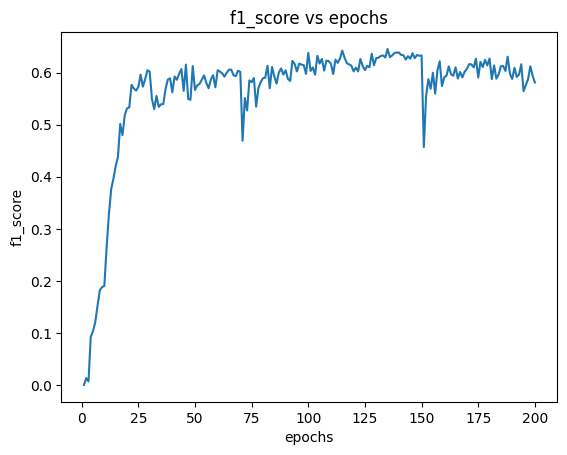

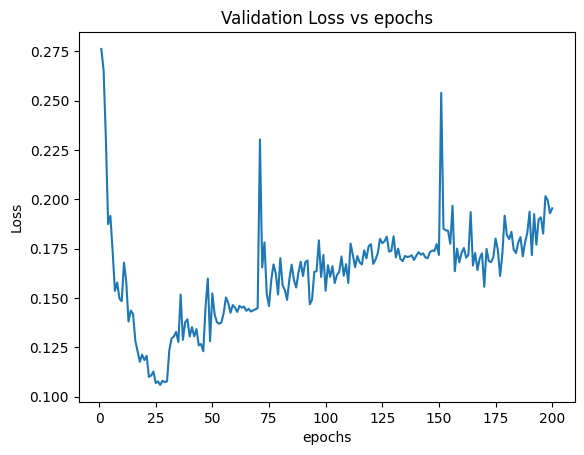

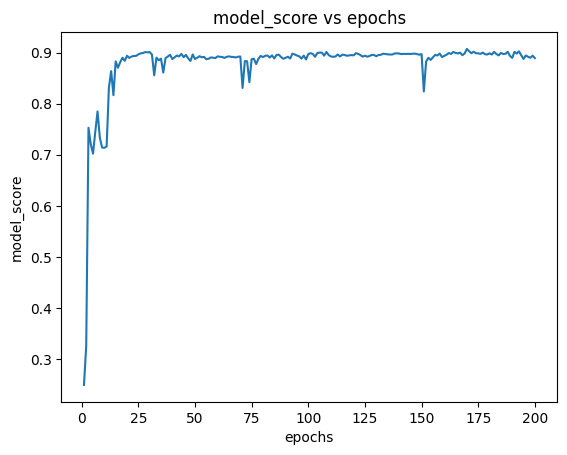

In [7]:
k = len(f1_arr)
plt.figure(1)
#plt.plot(sorted(list(set(roc_epochs))), f1_arr)
plt.plot(range(1,k+1), f1_arr)
plt.xlabel("epochs")
plt.ylabel("f1_score")
plt.title('f1_score vs epochs')

plt.figure(2)
#plt.plot(sorted(list(set(roc_epochs))), loss_arr)
plt.plot(range(1,k+1), loss_arr)
plt.xlabel("epochs")
plt.ylabel("Loss")
plt.title('Validation Loss vs epochs')

plt.figure(3)
#plt.plot(sorted(list(set(roc_epochs))), f1_arr)
plt.plot(range(1,k+1), model_arr)
plt.xlabel("epochs")
plt.ylabel("model_score")
plt.title('model_score vs epochs')

print(max_ms) 

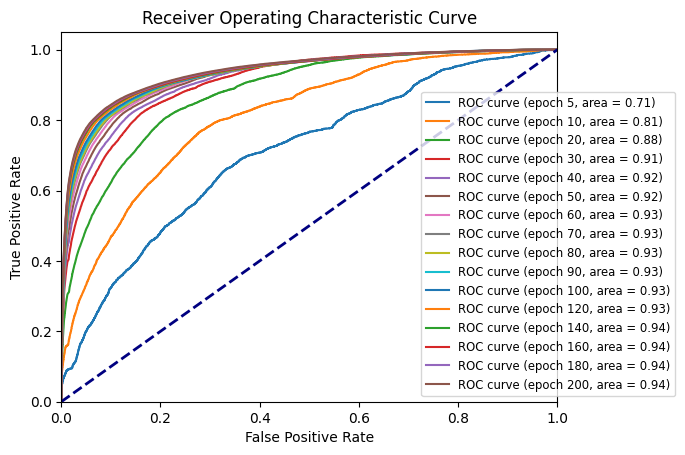

In [8]:
# plot ROC curve
fig2, ax2 = plt.subplots()
for i in range(len(roc_auc)):
    ax2.plot(roc_fpr[i], roc_tpr[i], label=f'ROC curve (epoch {roc_epochs[i]}, area = {roc_auc[i]:.2f})')
ax2.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
ax2.set_xlim([0.0, 1.0])
ax2.set_ylim([0.0, 1.05])
ax2.set_xlabel('False Positive Rate')
ax2.set_ylabel('True Positive Rate')
ax2.set_title('Receiver Operating Characteristic Curve')
# Set the properties for the legend
legend = ax2.legend(loc='lower right', bbox_to_anchor=(1.25, 0), fontsize='small', framealpha=0.8)

In [9]:
from sklearn.metrics import precision_recall_curve, roc_auc_score, f1_score
from tabulate import tabulate

model.eval()
val_preds, val_labels = [], []
with torch.no_grad():
    for images, labels in tqdm(val_dataloader):
        images, labels = images.to(device), labels.to(device)
            
        # Forward pass
        outputs = model(images)
        outputs = torch.sigmoid(outputs)
        
        # append the predicted probabilities and true labels to lists for calculating ROC AUC score later
        val_preds += outputs.tolist()
        val_labels += labels.tolist()

val_labels = np.array(val_labels)
val_preds = np.array(val_preds)
threshold = 0.5  # set your threshold value here
thresholded_val_preds = np.where(val_preds > threshold, 1, 0)

# Calculate the precision, recall, and AUC score for each label using scikit-learn's functions
metrics_dict = {}
for label in range(num_classes):
    precision, recall, _ = precision_recall_curve(val_labels[label], thresholded_val_preds[label])
    auc = roc_auc_score(val_labels[label], val_preds[label])
    f1 = f1_score(val_labels[label], thresholded_val_preds[label], average='binary', zero_division=1)
    metrics_dict[label] = {'Precision': precision, 'Recall': recall, 'F1': f1, 'AUC': auc}
    
# Print the dictionary in tabular format using the tabulate library
headers = ['Label', 'Precision', 'Recall', 'F1', 'AUC']
table = []
for label in range(num_classes):
    row = [label]
    for metric in ['Precision', 'Recall', 'F1', 'AUC']:
        values = metrics_dict[label][metric]
        if values.size > 0:
            value_str = '{:.4f}'.format(values.mean(), values.max())
        else:
            value_str = '0.00'
        row.append(value_str)
    table.append(row)

print(tabulate(table, headers=headers))

100%|██████████| 28/28 [00:06<00:00,  4.25it/s]

  Label    Precision    Recall      F1     AUC
-------  -----------  --------  ------  ------
      0       0.35      0.3333  0       0.9474
      1       0.6833    0.6667  1       1
      2       0.6833    0.6667  1       1
      3       0.35      0.3333  0       0.8947
      4       0.525     0.5     0       1
      5       0.6833    0.6667  1       1
      6       0.525     0.5     0       0.8947
      7       0.35      0.3333  0       0.9474
      8       0.35      0.3333  0       0.9474
      9       0.6833    0.6667  1       1
     10       0.6833    0.6667  1       1
     11       0.6833    0.6667  1       1
     12       0.6833    0.6667  1       1
     13       0.6833    0.6667  1       1
     14       0.6833    0.6667  1       1
     15       0.5167    0.6667  0.6667  1
     16       0.35      0.3333  0       0.8421
     17       0.35      0.3333  0       0.8421
     18       0.6833    0.6667  1       1
     19       0.7       0.5     0.6667  1
